<div align="center">
  <img src="https://th.bing.com/th/id/OIP.1735ji7nOUMLcDRyPlKIwgHaD3?rs=1&pid=ImgDetMain" alt="logo-tensorflow+keras" width="200px" style="border-radius: 10px; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.2);">
</div>

# **Mangrove Research with PyTorch**
> *Building The Efficient Model Res4Net-CBAM for Image Classification and Detection Mangrove Leaf in Eco-village Cuku NyiNyi*

## **`Install Depedencies`**

In [ ]:
# !pip install -U albumentations    # Library untuk augmentasi gambar (Install kalau tidak ada)
!pip install torchsummary         # Library untuk melihat arsitektur model

## **`Library`**

In [2]:
# LIBRARY OPRASIONAL YANG DIGUNAKAN DIDALAM SETUP DASAR
import os                                                     # Library Fungsional dalam operasi komputasi
import glob                                                   # Library untuk pencarian file berdasarkan pola path  
from tqdm import tqdm                                         # Library fungsionalitas adaptasi proses bar
import random                                                 # Library pemilihan random (pada warna di visualisasi)

# LIBRARY KHUSUS PRA-PEMROSESAN GAMBAR (IMAGE PREPROCESSING)
import cv2                                                    # Library yang umum digunakan untuk permosesan gambar
from PIL import Image                                         # Library untuk memanipulasi gambar
import numpy as np                                            # Vektor, Matriks, tensor manipulation
import albumentations as A                                    # Library untuk augmentasi 'Albumentations'
from albumentations.pytorch import ToTensorV2                 # Fungsi dari library pytorch untuk mengubah hasil augmentasi ke bentuk tensor

# LIBRARY KHUSUS DARI PYTORCH UNTUK MLP DAN NN MODEL
import torch                                                  # Framework PyTorch
import torch.nn as nn                                         # Neural Network Setting PyTorch
import torch.nn.functional as F                               # Fungsional Setup
import torch.optim as optim                                   # Optimasi PyTorch (ex: Adam dkk.)
from torch.utils.data import DataLoader,random_split, Dataset # Utilitas Data (Pembagian data, Data Loader)
from torch.utils.data import Subset                           # Subset dataset spliting Distribution
from torch.cuda.amp import autocast, GradScaler               # CUDA setup for GPU Runner with PyTorch
from torch.utils.tensorboard import SummaryWriter             # Tensorboard Visualization from trainer record
from torchsummary import summary                              # Library untuk melihat arsitektur model

# LIBRARY KHUSUS DARI PYTORCH UNTUK PEMROSESAN GAMBAR (TORCHVISION)
import torchvision                                            # Library PyTorch Khusus pemodelan gambar
import torchvision.transforms as transforms                   # Transformasi + Augmentasi
from torchvision import datasets, models                      # Load pre-trained model (ResNet dan VGG-16)
from torchvision.transforms import v2                         # Transformasi gambar tambahan (Gaussian blur, Saturation, Noise dsb) dan intergrasi dengan Albumentations
import torchvision.utils as vutils

# LIBRARY SCIKIT-LEARN (EVALUASI MODEL)
from sklearn.metrics import confusion_matrix, roc_curve, auc  # Metrik Confussion Matrix dan ROC/AUC
from sklearn.metrics import accuracy_score, precision_score   # skor akurasi dan presisi 
from sklearn.metrics import recall_score, f1_score            # Skor recall dan F1-Score
from sklearn.metrics import classification_report             # Metrik Classification Report
from sklearn.preprocessing import LabelBinarizer              # Label binarizer for ROC/AUC index
from sklearn.model_selection import StratifiedShuffleSplit    # Stratified Shuffle Split 

# LIBRARY KHUSUS UNTUK PLOT
import matplotlib.pyplot as plt                               # Library Plot (Dasar)
import seaborn as sns                                         # Library Aesthetic Plot + Themes

# LIBRARY KHUSUS UNTUK PENANGANAN WARNING 
import warnings                                               # Library warning 
warnings.simplefilter(action='ignore', category=FutureWarning)# Pencegahan warning dari jenis "Future warning"

## **`Arsitektur Res4Net-CBAM`**
> Meliputi penggabungan 4 Block Residual dan CBAM diantaranya sebagai layer attention

In [ ]:
# 1. Modul Perhatian CBAM (Convolutional Block Attention Module)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        # Global Average Pooling untuk mengagregasi informasi spasial
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Global Maximum Pooling untuk mengagregasi informasi spasial
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Multi-Layer Perceptron (MLP) bersama
        # Menggunakan Conv2d dengan kernel 1x1 sebagai pengganti Fully Connected layer
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Memproses melalui Average Pool dan MLP
        avg_out = self.mlp(self.avg_pool(x))
        # Memproses melalui Max Pool dan MLP
        max_out = self.mlp(self.max_pool(x))
        # Menjumlahkan keluaran MLP dan menerapkan Sigmoid
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'Ukuran kernel harus 3 atau 7'
        padding = 3 if kernel_size == 7 else 1 # Padding yang sesuai untuk menjaga dimensi spasial
        # Konvolusi untuk memproses peta fitur yang digabungkan
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Average Pooling sepanjang dimensi saluran
        avg_out = torch.mean(x, dim=1, keepdim=True)
        # Maximum Pooling sepanjang dimensi saluran
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # Menggabungkan hasil pooling
        x_cat = torch.cat([avg_out, max_out], dim=1)
        # Menerapkan konvolusi dan Sigmoid
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, spatial_kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel_size)

    def forward(self, x):
        # Perhatian Saluran: F' = Mc(F) * F
        mc = self.channel_attention(x)
        x_channel_att = x * mc 

        # Perhatian Spasial: F'' = Ms(F') * F'
        ms = self.spatial_attention(x_channel_att)
        x_spatial_att = x_channel_att * ms 
        return x_spatial_att

In [ ]:
# Blok Residual
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1, inc=False):
        super(ResidualBlock, self).__init__()
        self.stride = stride

        # Jalur Utama (Main Path)
        # Conv 1x1 pertama: Mengubah jumlah saluran
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu1 = nn.LeakyReLU(inplace=True)

        # Conv 3x3: Melakukan downsampling spasial jika stride > 1
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.relu2 = nn.LeakyReLU(inplace=True)

        # Conv 1x1 kedua: Menyesuaikan jumlah saluran akhir blok
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels) 
        # LeakyReLU akhir diterapkan setelah penambahan sambungan lompat

        # Jalur Sambungan Lompat (Shortcut Path)
        self.shortcut = nn.Sequential()
        # Jika stride > 1 atau jumlah saluran masukan tidak sama dengan keluaran,
        # gunakan konvolusi 1x1 di jalur lompat untuk mencocokkan dimensi
        if stride!= 1 or in_channels!= out_channels:
            if inc:
              self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
              )
            else:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                  nn.BatchNorm2d(out_channels)
              )
        
        self.final_relu = nn.LeakyReLU(inplace=True) # LeakyReLU setelah penambahan

    def forward(self, x, x_2=None):
        identity = x # Simpan masukan untuk sambungan lompat

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        try:
          cut = self.shortcut(identity) # Skip Connection
          h, w = math.ceil(cut.shape[2]/2), math.ceil(cut.shape[3]/2)
          cut = F.interpolate(cut, size=(h, w), mode="bilinear", align_corners=False)
          out += cut
        except:
          cut = self.shortcut(x_2) # Skip Connection 
          h, w = math.ceil(x_2.shape[2]/4), math.ceil(x_2.shape[3]/4)
          cut = F.interpolate(cut, size=(h, w), mode="bilinear", align_corners=False)
          out += cut
        out = self.final_relu(out) # Terapkan LeakyReLU akhir setelah penambahan
        return out

# Model Res4net-CBAM
class Res4Net_CBAM(nn.Module):
    def __init__(self, num_classes=3):
        super(Res4net_CBAM, self).__init__()
        
        # Lapisan Awal (Pemrosesan Masukan)
        # Conv2D_0: Kernel 7x7, Stride 2, Padding 3 untuk output 64x64
        self.conv0 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu0 = nn.LeakyReLU(inplace=True)
        # MaxPool2D_0: Kernel 2x2, Stride 2 untuk output 32x32
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Blok Residual dengan CBAM
        # RB1: Masukan 32x32x64 -> Keluaran 16x16x256
        self.rb1 = ResidualBlock(in_channels=64, mid_channels=128, out_channels=256, stride=2, inc=True)
        self.cbam1 = CBAM(in_channels=256)

        # RB2: Masukan 16x16x256 -> Keluaran 8x8x256
        self.rb2 = ResidualBlock(in_channels=256, mid_channels=128, out_channels=256, stride=2)
        self.cbam2 = CBAM(in_channels=256)

        # RB3: Masukan 8x8x256 -> Keluaran 4x4x512
        self.rb3 = ResidualBlock(in_channels=256, mid_channels=256, out_channels=512, stride=2)
        self.cbam3 = CBAM(in_channels=512)

        # RB4: Masukan 4x4x512 -> Keluaran 2x2x512
        self.rb4 = ResidualBlock(in_channels=512, mid_channels=256, out_channels=512, stride=2)
        self.cbam4 = CBAM(in_channels=512)

        # Kepala Klasifikasi Akhir
        # Global Average Pooling untuk meratakan fitur
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 
        # Lapisan Fully Connected pertama
        self.fc1 = nn.Linear(512, 1024)
        self.relu_fc1 = nn.ReLU(inplace=True)
        # Lapisan Dropout
        self.dropout = nn.Dropout(0.3)
        # Lapisan Fully Connected terakhir (Softmax)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Lapisan Awal
        x = self.conv0(x)
        x = self.bn0(x)
        x_ = self.relu0(x)
        x = self.maxpool(x_)

        # Blok Residual dengan CBAM
        # Keluaran blok residual dikalikan dengan keluaran CBAM
        x = self.rb1(x, x_) # 1
        x = self.cbam1(x) * x 
        
        x = self.rb2(x) # 2
        x = self.cbam2(x) * x

        x = self.rb3(x) # 3
        x = self.cbam3(x) * x

        x = self.rb4(x) # 4
        x = self.cbam4(x) * x

        # Kepala Klasifikasi Akhir
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x) 
        return x


# Cek model
if __name__ == '__main__':
    model_cbam = Res4Net_CBAM(num_classes=3) # 3 Classes (After Defined)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Device are used
    model_cbam.to(device) # Direct model to device
    summary(model_cbam, input_size=(3, 224, 224)) # Summary model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
         LeakyReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
         LeakyReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 28, 28]         147,456
       BatchNorm2d-9          [-1, 128, 28, 28]             256
        LeakyReLU-10          [-1, 128, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]          16,384
      BatchNorm2d-12          [-1, 128, 28, 28]             256
           Conv2d-13          [-1, 128, 28, 28]           8,192
      BatchNorm2d-14          [-1, 128,

## **`Setup Trainer and Evaluator`**
> Augmentasi, Pembagian Data dan Evaluasi Training

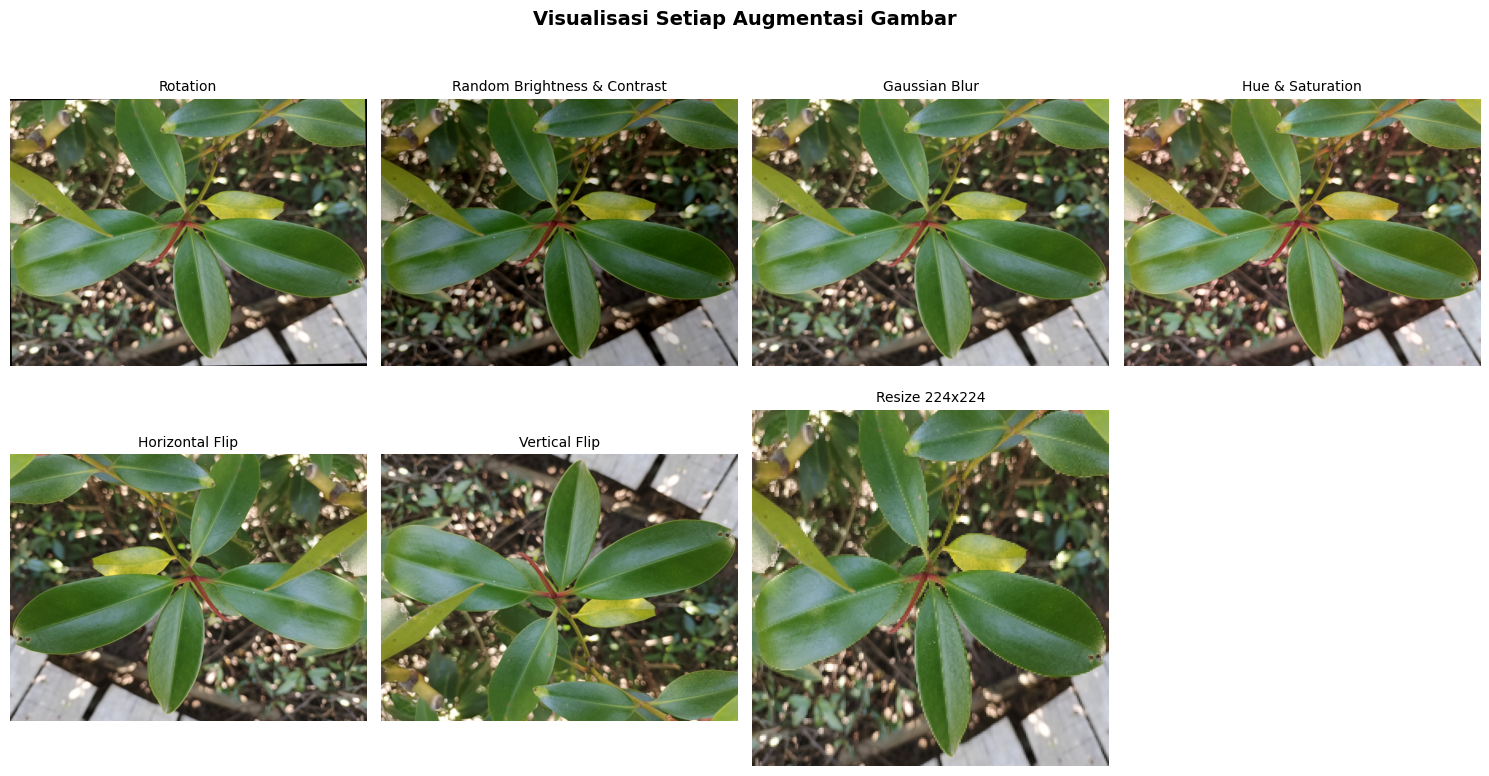

In [ ]:
# Load gambar dan ubah dari BGR ke RGB
image = cv2.imread("/kaggle/input/mangrove-tester/Rhizopora_Apiculata_749/Apiculata_105.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Daftar transformasi per augmentasi (tanpa chaining)
transformations = [
    ("Rotation", A.Rotate(limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 1))),
    ("Random Brightness & Contrast", A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0)),
    ("Gaussian Blur", A.GaussianBlur(blur_limit=(3, 3), p=1.0)),
    ("Hue & Saturation", A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, p=1.0)),
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Vertical Flip", A.VerticalFlip(p=1.0)),
    ("Resize 224x224", A.Resize(224, 224))
]

# Plot setiap transformasi satu per satu
plt.figure(figsize=(15, 8))

for i, (name, transform) in enumerate(transformations):
    augmented = transform(image=image)['image']
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented)
    plt.title(name, fontsize=10)
    plt.axis("off")

plt.suptitle("Visualisasi Setiap Augmentasi Gambar", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### **`Setup Dataset Untuk Training`**
> Meliputi pembagian dataset, augmentasi, jumlah batch size dan input ke DataLoader

In [11]:
# Location of Dataset
data_dir = '/kaggle/input/mangrove-dataset/datamangrove'
raw_dataset = datasets.ImageFolder(root=data_dir)

# Extract labels for stratification split format
labels = [label for _, label in raw_dataset.samples]

# Stratified split: 80% train, 20% test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(np.zeros(len(labels)), labels))

# Subset dataset sesuai dengan indeks yang diperoleh dari stratifikasi
raw_train_dataset = Subset(raw_dataset, train_idx)
raw_test_dataset = Subset(raw_dataset, test_idx)

# Augmentasi untuk dataset training
train_transform = A.Compose([
    A.Rotate(limit=20, p=0.5),  # Rotasi terbatas ±20°
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Kontras dan kecerahan
    A.GaussianBlur(blur_limit=(3, 3), p=0.3),  # Blur ringan
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, p=0.5), # Hue dan saturasi
    A.HorizontalFlip(p=0.5), # Membalik secara horizontal
    A.VerticalFlip(p=0.5), # Membalik secara vertikal
    A.Resize(224, 224),  # Resize agar semua gambar memiliki ukuran yang sama
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalisasi
    ToTensorV2()  # Mengubah ke bentuk tensor
])

# Untuk dataset validasi/test, hanya dilakukan normalisasi tanpa augmentasi
test_transform = A.Compose([
    A.Resize(224, 224),  # Resize ke 224x224
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalisasi
    ToTensorV2(),  # Konversi ke tensor PyTorch
])

# Dataset wrapper untuk augmentasi on-the-fly
class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL image to numpy array
        
        if self.transform:
            augmented = self.transform(image=image) # Doing augmentation
            image = augmented['image'] 
        
        return image, label

# Terapkan augmentasi hanya pada dataset training
train_dataset = AlbumentationsDataset(raw_train_dataset, transform=train_transform)  # Train dataset dengan augmentasi
test_dataset = AlbumentationsDataset(raw_test_dataset, transform=test_transform)  # Test dataset tanpa augmentasi

# DataLoader untuk training & testing
batch_size = 32 # Jumlah batch size yang digunakan karna dataset kecil
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) # Data train sudah siap 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) # Data test sudah siap

### **`Setup Trainer and Evaluator`**
>  Pipeline untuk melatih dan mengevaluasi model per-epoch dengan dikombinasikan optimizer dan learning rate

In [12]:
# === Trainer and Evaluator with TensorBoard Checker === 
def train_and_evaluate_model(model_class, train_loader, val_loader, criterion, device, num_classes, num_epochs=100, checkpoint_dir='checkpoints', log_dir='runs'):
    optimizers = {
        'Adam': optim.Adam,
        'SGD': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
    }
    learning_rates = [0.001, 0.0001, 0.00001]

    best_overall_loss = float('inf')
    best_overall_acc = 0.0
    best_model_path = None
    all_results = {}

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    scaler = GradScaler()

    for opt_name, opt_func in optimizers.items():
        for lr in learning_rates:
            tag = f"{opt_name}_lr{lr}"
            print(f"\n=== Training with {tag} ===")

            # Init TensorBoard writer
            writer = SummaryWriter(log_dir=os.path.join(log_dir, tag))

            model = model_class(num_classes=num_classes).to(device)
            optimizer = opt_func(model.parameters(), lr=lr)
            train_losses, val_losses = [], []
            train_accuracies, val_accuracies = [], []
            best_val_loss = float('inf')
            best_val_accuracy = 0.0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                correct = 0
                total = 0

                for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                train_loss = running_loss / len(train_loader)
                train_accuracy = correct / total * 100
                train_losses.append(train_loss)
                train_accuracies.append(train_accuracy)

                model.eval()
                val_running_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        with autocast():
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                val_loss = val_running_loss / len(val_loader)
                val_accuracy = val_correct / val_total * 100
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                # TensorBoard log
                writer.add_scalar('Loss/Train', train_loss, epoch)
                writer.add_scalar('Loss/Validation', val_loss, epoch)
                writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
                writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

                # Save model jika meningkat signifikan
                improved = (val_loss < best_val_loss - 0.001) or (val_accuracy > best_val_accuracy + 0.5)
                checkpoint_path = f"/kaggle/working/{checkpoint_dir}/Res4Net_CBAM_{tag}.pth"
                if improved:
                    best_val_loss = val_loss
                    best_val_accuracy = val_accuracy
                    torch.save(model.state_dict(), checkpoint_path)

                    if val_loss < best_overall_loss or val_accuracy > best_overall_acc:
                        best_overall_loss = val_loss
                        best_overall_acc = val_accuracy
                        best_model_path = checkpoint_path

                # Logging singkat tiap 5 epoch atau saat improve
                if epoch % 5 == 0 or epoch == num_epochs - 1 or improved:
                    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

            writer.close()
            all_results[tag] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies
            }

    print(f"\n✅ Best model saved at: {best_model_path}")
    print(f"   → Val Loss: {best_overall_loss:.4f} | Val Acc: {best_overall_acc:.2f}%")
    return best_model_path, all_results

In [ ]:
# === TRAINING PLOT FOR ALL RESULT ===
def plot_training_metrics(all_results, num_epochs):
    """
    Plot training and validation losses and accuracies for all optimizer and learning rate combinations,
    with simplified legend (1 color per key).
    """
    epochs = range(1, num_epochs + 1) # 
    fig, axes = plt.subplots(2, 2, figsize=(14, 9)) # Besarnya plot dan subplot yang terbentuk
    # colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"] # Opsi warna lainnya
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    random.shuffle(colors)

    simplified_handles = []
    simplified_labels = []

    for idx, (key, results) in enumerate(all_results.items()):
        color = colors[idx % len(colors)]
        train_losses = results["train_losses"]
        val_losses = results["val_losses"]
        train_accuracies = results["train_accuracies"]
        val_accuracies = results["val_accuracies"]

        # Plot all curves with same color
        axes[0, 0].plot(epochs, train_losses, marker=".", color=color)
        axes[0, 1].plot(epochs, val_losses, marker=".", color=color)
        axes[1, 0].plot(epochs, train_accuracies, marker=".", color=color)
        axes[1, 1].plot(epochs, val_accuracies, marker=".", color=color)

        # Simpan satu handle untuk legenda
        handle, = axes[0, 0].plot([], [], color=color, label=key)
        simplified_handles.append(handle)
        simplified_labels.append(f"{key}")

    # Label & grid untuk tiap plot
    axes[0, 0].set_title("Training Loss")
    axes[0, 1].set_title("Validation Loss")
    axes[1, 0].set_title("Training Accuracy")
    axes[1, 1].set_title("Validation Accuracy")
    
    for ax in axes.flat:
        ax.set_xlabel("Epochs")
        ax.grid(True)

    axes[0, 0].set_ylabel("Loss")
    axes[1, 0].set_ylabel("Accuracy (%)")

    # Letakkan legenda di bawah
    fig.legend(simplified_handles, simplified_labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=2, title="Optimizer & Learning Rate") # Memberikan legenda
    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Mengatur layout
    plt.show() # Menampilkan plot

In [ ]:
# Pelatihan Model serta penyimpanan seluruh hasil model
best_model_path, all_results = train_and_evaluate_model(
    model_class=Res4Net_CBAM, # Model
    train_loader=train_loader, # Data train
    val_loader=test_loader,  # Data validasi
    criterion=nn.CrossEntropyLoss(), # Loss 
    device=device, # Seting Device 
    num_classes=3, # Jumlah Kelas 
    num_epochs=100 # Jumlah Epoch
)


=== Training with Adam_lr0.001 ===


[Epoch 1] Train Loss: 1.0056 | Train Acc: 43.75% | Val Loss: 1.0956 | Val Acc: 33.33%


[Epoch 2] Train Loss: 0.7765 | Train Acc: 67.50% | Val Loss: 1.0550 | Val Acc: 40.00%


[Epoch 3] Train Loss: 0.6355 | Train Acc: 70.83% | Val Loss: 0.7569 | Val Acc: 60.00%


[Epoch 6] Train Loss: 0.6784 | Train Acc: 70.83% | Val Loss: 1.3647 | Val Acc: 48.33%


[Epoch 7] Train Loss: 0.6996 | Train Acc: 70.42% | Val Loss: 0.4565 | Val Acc: 80.00%


[Epoch 9] Train Loss: 0.4020 | Train Acc: 84.58% | Val Loss: 0.3116 | Val Acc: 93.33%


[Epoch 11] Train Loss: 0.4886 | Train Acc: 79.17% | Val Loss: 0.8367 | Val Acc: 58.33%


[Epoch 15] Train Loss: 0.3396 | Train Acc: 83.33% | Val Loss: 0.2235 | Val Acc: 91.67%


[Epoch 16] Train Loss: 0.3347 | Train Acc: 89.17% | Val Loss: 0.2405 | Val Acc: 90.00%


[Epoch 18] Train Loss: 0.2476 | Train Acc: 90.42% | Val Loss: 0.1980 | Val Acc: 93.33%


[Epoch 19] Train Loss: 0.2794 | Train Acc: 89.17% | Val Loss: 0.1699 | Val Acc: 90.00%


[Epoch 21] Train Loss: 0.2958 | Train Acc: 88.33% | Val Loss: 0.7764 | Val Acc: 73.33%


[Epoch 25] Train Loss: 0.2582 | Train Acc: 92.50% | Val Loss: 0.0799 | Val Acc: 96.67%


[Epoch 26] Train Loss: 0.2674 | Train Acc: 92.92% | Val Loss: 0.2238 | Val Acc: 88.33%


[Epoch 29] Train Loss: 0.0979 | Train Acc: 96.25% | Val Loss: 0.0747 | Val Acc: 96.67%


[Epoch 30] Train Loss: 0.0950 | Train Acc: 97.08% | Val Loss: 0.0687 | Val Acc: 96.67%


[Epoch 31] Train Loss: 0.1939 | Train Acc: 93.33% | Val Loss: 0.4395 | Val Acc: 85.00%


[Epoch 36] Train Loss: 0.1951 | Train Acc: 94.17% | Val Loss: 0.4839 | Val Acc: 90.00%


[Epoch 41] Train Loss: 0.2703 | Train Acc: 92.08% | Val Loss: 0.7408 | Val Acc: 73.33%


[Epoch 46] Train Loss: 0.0453 | Train Acc: 97.92% | Val Loss: 0.2227 | Val Acc: 93.33%


[Epoch 51] Train Loss: 0.0828 | Train Acc: 97.50% | Val Loss: 0.1559 | Val Acc: 93.33%


[Epoch 52] Train Loss: 0.1328 | Train Acc: 96.25% | Val Loss: 0.0630 | Val Acc: 98.33%


[Epoch 56] Train Loss: 0.0677 | Train Acc: 98.75% | Val Loss: 0.0539 | Val Acc: 98.33%


[Epoch 57] Train Loss: 0.0463 | Train Acc: 98.33% | Val Loss: 0.0349 | Val Acc: 100.00%


[Epoch 61] Train Loss: 0.1188 | Train Acc: 94.17% | Val Loss: 0.1710 | Val Acc: 95.00%


[Epoch 66] Train Loss: 0.0835 | Train Acc: 97.92% | Val Loss: 0.5123 | Val Acc: 85.00%


[Epoch 71] Train Loss: 0.0287 | Train Acc: 98.33% | Val Loss: 0.0613 | Val Acc: 98.33%


[Epoch 76] Train Loss: 0.0644 | Train Acc: 97.92% | Val Loss: 0.2543 | Val Acc: 88.33%


[Epoch 77] Train Loss: 0.0172 | Train Acc: 99.58% | Val Loss: 0.0294 | Val Acc: 100.00%


[Epoch 81] Train Loss: 0.0331 | Train Acc: 98.75% | Val Loss: 0.0925 | Val Acc: 96.67%


[Epoch 84] Train Loss: 0.1120 | Train Acc: 99.17% | Val Loss: 0.0116 | Val Acc: 100.00%


[Epoch 86] Train Loss: 0.0763 | Train Acc: 97.08% | Val Loss: 0.0565 | Val Acc: 96.67%


[Epoch 91] Train Loss: 0.0589 | Train Acc: 98.33% | Val Loss: 0.1263 | Val Acc: 95.00%


[Epoch 96] Train Loss: 0.0177 | Train Acc: 99.58% | Val Loss: 0.0087 | Val Acc: 100.00%


[Epoch 100] Train Loss: 0.0816 | Train Acc: 97.50% | Val Loss: 0.0710 | Val Acc: 96.67%

=== Training with Adam_lr0.0001 ===


[Epoch 1] Train Loss: 1.0858 | Train Acc: 31.25% | Val Loss: 1.0983 | Val Acc: 33.33%


[Epoch 2] Train Loss: 1.0165 | Train Acc: 52.92% | Val Loss: 1.0967 | Val Acc: 38.33%


[Epoch 3] Train Loss: 0.9157 | Train Acc: 61.67% | Val Loss: 1.0596 | Val Acc: 61.67%


[Epoch 4] Train Loss: 0.7682 | Train Acc: 67.50% | Val Loss: 0.9633 | Val Acc: 61.67%


[Epoch 5] Train Loss: 0.6396 | Train Acc: 75.42% | Val Loss: 0.7900 | Val Acc: 76.67%


[Epoch 6] Train Loss: 0.5257 | Train Acc: 78.75% | Val Loss: 0.4851 | Val Acc: 86.67%


[Epoch 9] Train Loss: 0.3150 | Train Acc: 87.92% | Val Loss: 0.2640 | Val Acc: 93.33%


[Epoch 10] Train Loss: 0.2913 | Train Acc: 90.42% | Val Loss: 0.2373 | Val Acc: 91.67%


[Epoch 11] Train Loss: 0.2343 | Train Acc: 93.75% | Val Loss: 0.1993 | Val Acc: 96.67%


[Epoch 12] Train Loss: 0.2040 | Train Acc: 92.08% | Val Loss: 0.1652 | Val Acc: 93.33%


[Epoch 15] Train Loss: 0.2055 | Train Acc: 94.17% | Val Loss: 0.1386 | Val Acc: 96.67%


[Epoch 16] Train Loss: 0.1466 | Train Acc: 95.42% | Val Loss: 0.1390 | Val Acc: 98.33%


[Epoch 20] Train Loss: 0.1291 | Train Acc: 95.83% | Val Loss: 0.1238 | Val Acc: 95.00%


[Epoch 21] Train Loss: 0.0959 | Train Acc: 95.83% | Val Loss: 0.1039 | Val Acc: 98.33%


[Epoch 26] Train Loss: 0.0686 | Train Acc: 98.33% | Val Loss: 0.1208 | Val Acc: 95.00%


[Epoch 28] Train Loss: 0.1028 | Train Acc: 96.67% | Val Loss: 0.0898 | Val Acc: 95.00%


[Epoch 29] Train Loss: 0.0729 | Train Acc: 98.75% | Val Loss: 0.0589 | Val Acc: 98.33%


[Epoch 31] Train Loss: 0.0636 | Train Acc: 97.08% | Val Loss: 0.1167 | Val Acc: 95.00%


[Epoch 36] Train Loss: 0.0991 | Train Acc: 95.83% | Val Loss: 0.1843 | Val Acc: 93.33%


[Epoch 39] Train Loss: 0.1239 | Train Acc: 96.25% | Val Loss: 0.0349 | Val Acc: 100.00%


[Epoch 41] Train Loss: 0.0901 | Train Acc: 98.33% | Val Loss: 0.0626 | Val Acc: 98.33%


[Epoch 46] Train Loss: 0.0372 | Train Acc: 99.17% | Val Loss: 0.0263 | Val Acc: 100.00%


[Epoch 51] Train Loss: 0.0683 | Train Acc: 97.92% | Val Loss: 0.0932 | Val Acc: 98.33%


[Epoch 56] Train Loss: 0.0413 | Train Acc: 98.33% | Val Loss: 0.0497 | Val Acc: 98.33%


[Epoch 61] Train Loss: 0.0473 | Train Acc: 97.92% | Val Loss: 0.0900 | Val Acc: 95.00%


[Epoch 62] Train Loss: 0.0634 | Train Acc: 97.92% | Val Loss: 0.0179 | Val Acc: 100.00%


[Epoch 66] Train Loss: 0.1046 | Train Acc: 96.67% | Val Loss: 0.0360 | Val Acc: 100.00%


[Epoch 71] Train Loss: 0.0279 | Train Acc: 99.17% | Val Loss: 0.0219 | Val Acc: 100.00%


[Epoch 76] Train Loss: 0.0269 | Train Acc: 99.58% | Val Loss: 0.0308 | Val Acc: 100.00%


[Epoch 78] Train Loss: 0.0531 | Train Acc: 98.75% | Val Loss: 0.0156 | Val Acc: 100.00%


[Epoch 81] Train Loss: 0.0337 | Train Acc: 99.17% | Val Loss: 0.0713 | Val Acc: 96.67%


[Epoch 86] Train Loss: 0.0154 | Train Acc: 100.00% | Val Loss: 0.0657 | Val Acc: 98.33%


[Epoch 89] Train Loss: 0.0618 | Train Acc: 99.58% | Val Loss: 0.0094 | Val Acc: 100.00%


[Epoch 91] Train Loss: 0.0185 | Train Acc: 99.17% | Val Loss: 0.0391 | Val Acc: 98.33%


[Epoch 96] Train Loss: 0.0222 | Train Acc: 99.17% | Val Loss: 0.0537 | Val Acc: 98.33%


[Epoch 100] Train Loss: 0.0234 | Train Acc: 99.58% | Val Loss: 0.0539 | Val Acc: 98.33%

=== Training with Adam_lr1e-05 ===


[Epoch 1] Train Loss: 1.0986 | Train Acc: 35.00% | Val Loss: 1.0984 | Val Acc: 33.33%


[Epoch 4] Train Loss: 1.0685 | Train Acc: 44.58% | Val Loss: 1.0935 | Val Acc: 45.00%


[Epoch 5] Train Loss: 1.0663 | Train Acc: 50.42% | Val Loss: 1.0748 | Val Acc: 56.67%


[Epoch 6] Train Loss: 1.0463 | Train Acc: 51.67% | Val Loss: 1.0355 | Val Acc: 48.33%


[Epoch 7] Train Loss: 1.0388 | Train Acc: 52.08% | Val Loss: 0.9963 | Val Acc: 50.00%


[Epoch 8] Train Loss: 1.0218 | Train Acc: 52.92% | Val Loss: 0.9711 | Val Acc: 50.00%


[Epoch 9] Train Loss: 1.0057 | Train Acc: 55.42% | Val Loss: 0.9563 | Val Acc: 50.00%


[Epoch 10] Train Loss: 0.9981 | Train Acc: 55.00% | Val Loss: 0.9446 | Val Acc: 55.00%


[Epoch 11] Train Loss: 0.9908 | Train Acc: 56.25% | Val Loss: 0.9336 | Val Acc: 61.67%


[Epoch 12] Train Loss: 0.9841 | Train Acc: 59.17% | Val Loss: 0.9212 | Val Acc: 58.33%


[Epoch 13] Train Loss: 0.9766 | Train Acc: 56.25% | Val Loss: 0.9095 | Val Acc: 61.67%


[Epoch 14] Train Loss: 0.9453 | Train Acc: 60.00% | Val Loss: 0.9008 | Val Acc: 63.33%


[Epoch 15] Train Loss: 0.9315 | Train Acc: 60.83% | Val Loss: 0.8925 | Val Acc: 61.67%


[Epoch 16] Train Loss: 0.9072 | Train Acc: 62.50% | Val Loss: 0.8795 | Val Acc: 60.00%


[Epoch 17] Train Loss: 0.8961 | Train Acc: 61.25% | Val Loss: 0.8677 | Val Acc: 60.00%


[Epoch 18] Train Loss: 0.8753 | Train Acc: 64.17% | Val Loss: 0.8543 | Val Acc: 61.67%


[Epoch 19] Train Loss: 0.8512 | Train Acc: 65.42% | Val Loss: 0.8364 | Val Acc: 66.67%


[Epoch 20] Train Loss: 0.8208 | Train Acc: 69.17% | Val Loss: 0.8128 | Val Acc: 65.00%


[Epoch 21] Train Loss: 0.7942 | Train Acc: 68.33% | Val Loss: 0.7886 | Val Acc: 70.00%


[Epoch 22] Train Loss: 0.7656 | Train Acc: 71.67% | Val Loss: 0.7725 | Val Acc: 68.33%


[Epoch 23] Train Loss: 0.7493 | Train Acc: 71.25% | Val Loss: 0.7486 | Val Acc: 68.33%


[Epoch 24] Train Loss: 0.7006 | Train Acc: 72.50% | Val Loss: 0.7186 | Val Acc: 66.67%


[Epoch 25] Train Loss: 0.6976 | Train Acc: 71.67% | Val Loss: 0.6887 | Val Acc: 68.33%


[Epoch 26] Train Loss: 0.6661 | Train Acc: 72.92% | Val Loss: 0.6397 | Val Acc: 70.00%


[Epoch 27] Train Loss: 0.6452 | Train Acc: 74.58% | Val Loss: 0.6063 | Val Acc: 75.00%


[Epoch 28] Train Loss: 0.6115 | Train Acc: 79.58% | Val Loss: 0.5915 | Val Acc: 76.67%


[Epoch 29] Train Loss: 0.6080 | Train Acc: 80.83% | Val Loss: 0.5903 | Val Acc: 81.67%


[Epoch 30] Train Loss: 0.6040 | Train Acc: 80.00% | Val Loss: 0.5599 | Val Acc: 83.33%


[Epoch 31] Train Loss: 0.5871 | Train Acc: 80.42% | Val Loss: 0.5390 | Val Acc: 88.33%


[Epoch 32] Train Loss: 0.6026 | Train Acc: 82.08% | Val Loss: 0.5147 | Val Acc: 88.33%


[Epoch 33] Train Loss: 0.5141 | Train Acc: 85.00% | Val Loss: 0.5111 | Val Acc: 88.33%


[Epoch 34] Train Loss: 0.5391 | Train Acc: 83.33% | Val Loss: 0.4905 | Val Acc: 90.00%


[Epoch 35] Train Loss: 0.5105 | Train Acc: 85.42% | Val Loss: 0.4630 | Val Acc: 90.00%


[Epoch 36] Train Loss: 0.4714 | Train Acc: 87.50% | Val Loss: 0.4390 | Val Acc: 91.67%


[Epoch 37] Train Loss: 0.4891 | Train Acc: 89.17% | Val Loss: 0.4172 | Val Acc: 93.33%


[Epoch 38] Train Loss: 0.4545 | Train Acc: 87.50% | Val Loss: 0.3926 | Val Acc: 93.33%


[Epoch 39] Train Loss: 0.4174 | Train Acc: 89.58% | Val Loss: 0.3720 | Val Acc: 95.00%


[Epoch 40] Train Loss: 0.3904 | Train Acc: 91.67% | Val Loss: 0.3500 | Val Acc: 96.67%


[Epoch 41] Train Loss: 0.3551 | Train Acc: 91.67% | Val Loss: 0.3264 | Val Acc: 95.00%


[Epoch 42] Train Loss: 0.3762 | Train Acc: 90.42% | Val Loss: 0.2942 | Val Acc: 98.33%


[Epoch 43] Train Loss: 0.3429 | Train Acc: 91.67% | Val Loss: 0.2835 | Val Acc: 96.67%


[Epoch 44] Train Loss: 0.3781 | Train Acc: 90.42% | Val Loss: 0.2505 | Val Acc: 95.00%


[Epoch 45] Train Loss: 0.3002 | Train Acc: 92.50% | Val Loss: 0.2199 | Val Acc: 96.67%


[Epoch 46] Train Loss: 0.2649 | Train Acc: 95.00% | Val Loss: 0.2021 | Val Acc: 98.33%


[Epoch 49] Train Loss: 0.2777 | Train Acc: 94.17% | Val Loss: 0.1773 | Val Acc: 98.33%


[Epoch 50] Train Loss: 0.2134 | Train Acc: 96.25% | Val Loss: 0.1626 | Val Acc: 98.33%


[Epoch 51] Train Loss: 0.2245 | Train Acc: 95.42% | Val Loss: 0.1563 | Val Acc: 98.33%


[Epoch 52] Train Loss: 0.2207 | Train Acc: 95.42% | Val Loss: 0.1415 | Val Acc: 98.33%


[Epoch 53] Train Loss: 0.2425 | Train Acc: 94.58% | Val Loss: 0.1400 | Val Acc: 98.33%


[Epoch 54] Train Loss: 0.2217 | Train Acc: 93.75% | Val Loss: 0.1367 | Val Acc: 96.67%


[Epoch 55] Train Loss: 0.1855 | Train Acc: 95.83% | Val Loss: 0.1515 | Val Acc: 98.33%


[Epoch 56] Train Loss: 0.2136 | Train Acc: 93.33% | Val Loss: 0.1259 | Val Acc: 98.33%


[Epoch 57] Train Loss: 0.1759 | Train Acc: 96.67% | Val Loss: 0.1168 | Val Acc: 98.33%


[Epoch 61] Train Loss: 0.1374 | Train Acc: 97.08% | Val Loss: 0.1179 | Val Acc: 98.33%


[Epoch 62] Train Loss: 0.1638 | Train Acc: 95.83% | Val Loss: 0.0970 | Val Acc: 98.33%


[Epoch 63] Train Loss: 0.1372 | Train Acc: 97.92% | Val Loss: 0.0918 | Val Acc: 98.33%


[Epoch 64] Train Loss: 0.1331 | Train Acc: 97.50% | Val Loss: 0.0840 | Val Acc: 100.00%


[Epoch 65] Train Loss: 0.1491 | Train Acc: 96.25% | Val Loss: 0.0731 | Val Acc: 100.00%


[Epoch 66] Train Loss: 0.1260 | Train Acc: 96.67% | Val Loss: 0.0759 | Val Acc: 98.33%


[Epoch 71] Train Loss: 0.0927 | Train Acc: 98.33% | Val Loss: 0.0760 | Val Acc: 100.00%


[Epoch 75] Train Loss: 0.1007 | Train Acc: 97.92% | Val Loss: 0.0450 | Val Acc: 100.00%


[Epoch 76] Train Loss: 0.1078 | Train Acc: 97.92% | Val Loss: 0.0525 | Val Acc: 100.00%


[Epoch 81] Train Loss: 0.1092 | Train Acc: 96.25% | Val Loss: 0.0638 | Val Acc: 100.00%


[Epoch 85] Train Loss: 0.0721 | Train Acc: 98.33% | Val Loss: 0.0373 | Val Acc: 100.00%


[Epoch 86] Train Loss: 0.0943 | Train Acc: 98.33% | Val Loss: 0.0361 | Val Acc: 100.00%


[Epoch 91] Train Loss: 0.0528 | Train Acc: 98.75% | Val Loss: 0.0324 | Val Acc: 100.00%


[Epoch 92] Train Loss: 0.0872 | Train Acc: 97.08% | Val Loss: 0.0303 | Val Acc: 100.00%


[Epoch 93] Train Loss: 0.0648 | Train Acc: 98.75% | Val Loss: 0.0266 | Val Acc: 100.00%


[Epoch 96] Train Loss: 0.0781 | Train Acc: 97.50% | Val Loss: 0.0371 | Val Acc: 100.00%


[Epoch 100] Train Loss: 0.0605 | Train Acc: 97.50% | Val Loss: 0.0227 | Val Acc: 100.00%

=== Training with SGD_lr0.001 ===


[Epoch 1] Train Loss: 1.0963 | Train Acc: 36.25% | Val Loss: 1.0986 | Val Acc: 33.33%


[Epoch 4] Train Loss: 1.0533 | Train Acc: 43.33% | Val Loss: 1.0946 | Val Acc: 35.00%


[Epoch 5] Train Loss: 1.0391 | Train Acc: 38.33% | Val Loss: 1.0527 | Val Acc: 48.33%


[Epoch 6] Train Loss: 1.0278 | Train Acc: 46.25% | Val Loss: 0.9622 | Val Acc: 51.67%


[Epoch 7] Train Loss: 1.0279 | Train Acc: 40.83% | Val Loss: 0.9550 | Val Acc: 46.67%


[Epoch 8] Train Loss: 1.0334 | Train Acc: 42.50% | Val Loss: 0.9569 | Val Acc: 51.67%


[Epoch 9] Train Loss: 1.0155 | Train Acc: 49.17% | Val Loss: 0.9697 | Val Acc: 55.00%


[Epoch 10] Train Loss: 0.9991 | Train Acc: 55.83% | Val Loss: 0.9806 | Val Acc: 61.67%


[Epoch 11] Train Loss: 1.0006 | Train Acc: 53.33% | Val Loss: 0.9754 | Val Acc: 58.33%


[Epoch 12] Train Loss: 0.9800 | Train Acc: 57.92% | Val Loss: 1.0103 | Val Acc: 65.00%


[Epoch 13] Train Loss: 0.9627 | Train Acc: 55.00% | Val Loss: 1.0306 | Val Acc: 66.67%


[Epoch 14] Train Loss: 0.9280 | Train Acc: 58.33% | Val Loss: 0.9930 | Val Acc: 70.00%


[Epoch 16] Train Loss: 0.9079 | Train Acc: 59.17% | Val Loss: 0.9824 | Val Acc: 65.00%


[Epoch 17] Train Loss: 0.8573 | Train Acc: 70.42% | Val Loss: 0.9667 | Val Acc: 66.67%


[Epoch 18] Train Loss: 0.8550 | Train Acc: 67.08% | Val Loss: 0.8791 | Val Acc: 68.33%


[Epoch 19] Train Loss: 0.8390 | Train Acc: 67.08% | Val Loss: 0.7896 | Val Acc: 56.67%


[Epoch 21] Train Loss: 0.8299 | Train Acc: 65.83% | Val Loss: 1.0807 | Val Acc: 35.00%


[Epoch 22] Train Loss: 0.8384 | Train Acc: 65.83% | Val Loss: 0.8303 | Val Acc: 65.00%


[Epoch 23] Train Loss: 0.7832 | Train Acc: 72.08% | Val Loss: 0.7245 | Val Acc: 75.00%


[Epoch 26] Train Loss: 0.7292 | Train Acc: 72.50% | Val Loss: 0.7492 | Val Acc: 73.33%


[Epoch 27] Train Loss: 0.7137 | Train Acc: 75.83% | Val Loss: 0.7173 | Val Acc: 78.33%


[Epoch 30] Train Loss: 0.6850 | Train Acc: 72.08% | Val Loss: 0.6982 | Val Acc: 73.33%


[Epoch 31] Train Loss: 0.6593 | Train Acc: 75.00% | Val Loss: 0.7587 | Val Acc: 61.67%


[Epoch 32] Train Loss: 0.6593 | Train Acc: 72.92% | Val Loss: 0.6727 | Val Acc: 75.00%


[Epoch 33] Train Loss: 0.6602 | Train Acc: 72.92% | Val Loss: 0.6350 | Val Acc: 70.00%


[Epoch 34] Train Loss: 0.6138 | Train Acc: 76.67% | Val Loss: 0.6914 | Val Acc: 75.00%


[Epoch 36] Train Loss: 0.6060 | Train Acc: 75.42% | Val Loss: 0.6585 | Val Acc: 76.67%


[Epoch 38] Train Loss: 0.5705 | Train Acc: 78.75% | Val Loss: 0.6362 | Val Acc: 78.33%


[Epoch 39] Train Loss: 0.5865 | Train Acc: 75.42% | Val Loss: 0.6145 | Val Acc: 76.67%


[Epoch 41] Train Loss: 0.5923 | Train Acc: 75.83% | Val Loss: 0.5813 | Val Acc: 78.33%


[Epoch 43] Train Loss: 0.5336 | Train Acc: 80.83% | Val Loss: 0.5755 | Val Acc: 80.00%


[Epoch 44] Train Loss: 0.5097 | Train Acc: 83.75% | Val Loss: 0.5622 | Val Acc: 85.00%


[Epoch 46] Train Loss: 0.4788 | Train Acc: 85.00% | Val Loss: 0.5435 | Val Acc: 78.33%


[Epoch 48] Train Loss: 0.4683 | Train Acc: 85.42% | Val Loss: 0.4399 | Val Acc: 90.00%


[Epoch 51] Train Loss: 0.3819 | Train Acc: 89.17% | Val Loss: 0.4291 | Val Acc: 93.33%


[Epoch 52] Train Loss: 0.3691 | Train Acc: 88.33% | Val Loss: 0.4038 | Val Acc: 86.67%


[Epoch 53] Train Loss: 0.3381 | Train Acc: 90.83% | Val Loss: 0.3151 | Val Acc: 95.00%


[Epoch 56] Train Loss: 0.3299 | Train Acc: 90.00% | Val Loss: 0.3624 | Val Acc: 91.67%


[Epoch 60] Train Loss: 0.2844 | Train Acc: 94.17% | Val Loss: 0.2917 | Val Acc: 88.33%


[Epoch 61] Train Loss: 0.3657 | Train Acc: 86.25% | Val Loss: 0.4218 | Val Acc: 85.00%


[Epoch 62] Train Loss: 0.2734 | Train Acc: 90.83% | Val Loss: 0.2846 | Val Acc: 95.00%


[Epoch 63] Train Loss: 0.2601 | Train Acc: 91.67% | Val Loss: 0.2748 | Val Acc: 88.33%


[Epoch 66] Train Loss: 0.1497 | Train Acc: 97.50% | Val Loss: 0.2787 | Val Acc: 85.00%


[Epoch 71] Train Loss: 0.1908 | Train Acc: 94.17% | Val Loss: 0.2925 | Val Acc: 91.67%


[Epoch 73] Train Loss: 0.2585 | Train Acc: 90.83% | Val Loss: 0.2358 | Val Acc: 93.33%


[Epoch 76] Train Loss: 0.1981 | Train Acc: 92.50% | Val Loss: 0.4747 | Val Acc: 80.00%


[Epoch 77] Train Loss: 0.1620 | Train Acc: 94.58% | Val Loss: 0.1355 | Val Acc: 96.67%


[Epoch 79] Train Loss: 0.1690 | Train Acc: 95.00% | Val Loss: 0.1039 | Val Acc: 98.33%


[Epoch 81] Train Loss: 0.1758 | Train Acc: 95.83% | Val Loss: 0.0834 | Val Acc: 98.33%


[Epoch 86] Train Loss: 0.1376 | Train Acc: 96.67% | Val Loss: 0.1136 | Val Acc: 95.00%


[Epoch 91] Train Loss: 0.1411 | Train Acc: 95.83% | Val Loss: 0.1457 | Val Acc: 95.00%


[Epoch 96] Train Loss: 0.1546 | Train Acc: 95.00% | Val Loss: 0.1664 | Val Acc: 96.67%


[Epoch 100] Train Loss: 0.1056 | Train Acc: 96.25% | Val Loss: 0.0754 | Val Acc: 98.33%

=== Training with SGD_lr0.0001 ===


[Epoch 1] Train Loss: 1.1036 | Train Acc: 29.17% | Val Loss: 1.0986 | Val Acc: 33.33%


[Epoch 6] Train Loss: 1.1023 | Train Acc: 31.67% | Val Loss: 1.1006 | Val Acc: 21.67%


[Epoch 8] Train Loss: 1.0973 | Train Acc: 35.42% | Val Loss: 1.0952 | Val Acc: 35.00%


[Epoch 9] Train Loss: 1.0975 | Train Acc: 31.25% | Val Loss: 1.0927 | Val Acc: 36.67%


[Epoch 10] Train Loss: 1.0972 | Train Acc: 32.92% | Val Loss: 1.0911 | Val Acc: 35.00%


[Epoch 11] Train Loss: 1.0969 | Train Acc: 31.25% | Val Loss: 1.0907 | Val Acc: 35.00%


[Epoch 12] Train Loss: 1.0947 | Train Acc: 38.33% | Val Loss: 1.0876 | Val Acc: 36.67%


[Epoch 13] Train Loss: 1.0930 | Train Acc: 39.58% | Val Loss: 1.0864 | Val Acc: 35.00%


[Epoch 15] Train Loss: 1.0928 | Train Acc: 32.50% | Val Loss: 1.0849 | Val Acc: 35.00%


[Epoch 16] Train Loss: 1.0927 | Train Acc: 35.42% | Val Loss: 1.0844 | Val Acc: 35.00%


[Epoch 17] Train Loss: 1.0924 | Train Acc: 32.08% | Val Loss: 1.0818 | Val Acc: 33.33%


[Epoch 18] Train Loss: 1.0923 | Train Acc: 31.25% | Val Loss: 1.0806 | Val Acc: 33.33%


[Epoch 19] Train Loss: 1.0893 | Train Acc: 39.17% | Val Loss: 1.0785 | Val Acc: 33.33%


[Epoch 20] Train Loss: 1.0908 | Train Acc: 38.75% | Val Loss: 1.0721 | Val Acc: 30.00%


[Epoch 21] Train Loss: 1.0837 | Train Acc: 39.17% | Val Loss: 1.0730 | Val Acc: 33.33%


[Epoch 22] Train Loss: 1.0865 | Train Acc: 36.67% | Val Loss: 1.0713 | Val Acc: 33.33%


[Epoch 25] Train Loss: 1.0836 | Train Acc: 35.83% | Val Loss: 1.0681 | Val Acc: 33.33%


[Epoch 26] Train Loss: 1.0853 | Train Acc: 35.42% | Val Loss: 1.0627 | Val Acc: 31.67%


[Epoch 27] Train Loss: 1.0870 | Train Acc: 35.42% | Val Loss: 1.0591 | Val Acc: 31.67%


[Epoch 28] Train Loss: 1.0858 | Train Acc: 37.50% | Val Loss: 1.0576 | Val Acc: 31.67%


[Epoch 31] Train Loss: 1.0770 | Train Acc: 34.17% | Val Loss: 1.0561 | Val Acc: 31.67%


[Epoch 32] Train Loss: 1.0744 | Train Acc: 35.83% | Val Loss: 1.0514 | Val Acc: 31.67%


[Epoch 33] Train Loss: 1.0770 | Train Acc: 34.17% | Val Loss: 1.0485 | Val Acc: 31.67%


[Epoch 34] Train Loss: 1.0743 | Train Acc: 37.50% | Val Loss: 1.0425 | Val Acc: 31.67%


[Epoch 35] Train Loss: 1.0733 | Train Acc: 37.50% | Val Loss: 1.0400 | Val Acc: 28.33%


[Epoch 36] Train Loss: 1.0680 | Train Acc: 38.75% | Val Loss: 1.0364 | Val Acc: 30.00%


[Epoch 37] Train Loss: 1.0728 | Train Acc: 37.08% | Val Loss: 1.0313 | Val Acc: 31.67%


[Epoch 38] Train Loss: 1.0705 | Train Acc: 36.67% | Val Loss: 1.0286 | Val Acc: 33.33%


[Epoch 39] Train Loss: 1.0799 | Train Acc: 39.58% | Val Loss: 1.0216 | Val Acc: 35.00%


[Epoch 40] Train Loss: 1.0675 | Train Acc: 40.42% | Val Loss: 1.0209 | Val Acc: 36.67%


[Epoch 41] Train Loss: 1.0622 | Train Acc: 38.75% | Val Loss: 1.0256 | Val Acc: 41.67%


[Epoch 42] Train Loss: 1.0637 | Train Acc: 37.92% | Val Loss: 1.0205 | Val Acc: 38.33%


[Epoch 43] Train Loss: 1.0645 | Train Acc: 32.92% | Val Loss: 1.0152 | Val Acc: 48.33%


[Epoch 44] Train Loss: 1.0643 | Train Acc: 40.42% | Val Loss: 1.0081 | Val Acc: 43.33%


[Epoch 45] Train Loss: 1.0594 | Train Acc: 39.58% | Val Loss: 1.0087 | Val Acc: 48.33%


[Epoch 46] Train Loss: 1.0644 | Train Acc: 35.83% | Val Loss: 0.9986 | Val Acc: 43.33%


[Epoch 47] Train Loss: 1.0568 | Train Acc: 42.50% | Val Loss: 0.9977 | Val Acc: 48.33%


[Epoch 48] Train Loss: 1.0634 | Train Acc: 32.08% | Val Loss: 0.9934 | Val Acc: 51.67%


[Epoch 51] Train Loss: 1.0583 | Train Acc: 42.08% | Val Loss: 0.9914 | Val Acc: 46.67%


[Epoch 52] Train Loss: 1.0547 | Train Acc: 39.58% | Val Loss: 0.9830 | Val Acc: 46.67%


[Epoch 54] Train Loss: 1.0454 | Train Acc: 45.42% | Val Loss: 0.9790 | Val Acc: 46.67%


[Epoch 56] Train Loss: 1.0508 | Train Acc: 45.83% | Val Loss: 0.9748 | Val Acc: 51.67%


[Epoch 59] Train Loss: 1.0439 | Train Acc: 37.92% | Val Loss: 0.9712 | Val Acc: 51.67%


[Epoch 61] Train Loss: 1.0360 | Train Acc: 40.42% | Val Loss: 0.9698 | Val Acc: 51.67%


[Epoch 63] Train Loss: 1.0298 | Train Acc: 42.08% | Val Loss: 0.9678 | Val Acc: 53.33%


[Epoch 66] Train Loss: 1.0249 | Train Acc: 41.25% | Val Loss: 0.9688 | Val Acc: 51.67%


[Epoch 67] Train Loss: 1.0274 | Train Acc: 41.67% | Val Loss: 0.9636 | Val Acc: 53.33%


[Epoch 68] Train Loss: 1.0304 | Train Acc: 43.33% | Val Loss: 0.9620 | Val Acc: 51.67%


[Epoch 69] Train Loss: 1.0387 | Train Acc: 39.58% | Val Loss: 0.9595 | Val Acc: 55.00%


[Epoch 70] Train Loss: 1.0390 | Train Acc: 44.17% | Val Loss: 0.9581 | Val Acc: 51.67%


[Epoch 71] Train Loss: 1.0329 | Train Acc: 43.75% | Val Loss: 0.9570 | Val Acc: 53.33%


[Epoch 72] Train Loss: 1.0378 | Train Acc: 44.17% | Val Loss: 0.9551 | Val Acc: 55.00%


[Epoch 76] Train Loss: 1.0251 | Train Acc: 45.83% | Val Loss: 0.9569 | Val Acc: 51.67%


[Epoch 81] Train Loss: 1.0127 | Train Acc: 47.92% | Val Loss: 0.9555 | Val Acc: 53.33%


[Epoch 82] Train Loss: 1.0419 | Train Acc: 45.00% | Val Loss: 0.9534 | Val Acc: 53.33%


[Epoch 86] Train Loss: 1.0155 | Train Acc: 42.50% | Val Loss: 0.9526 | Val Acc: 56.67%


[Epoch 90] Train Loss: 1.0254 | Train Acc: 48.33% | Val Loss: 0.9507 | Val Acc: 53.33%


[Epoch 91] Train Loss: 1.0143 | Train Acc: 47.08% | Val Loss: 0.9507 | Val Acc: 50.00%


[Epoch 94] Train Loss: 1.0181 | Train Acc: 45.00% | Val Loss: 0.9510 | Val Acc: 55.00%


[Epoch 96] Train Loss: 1.0174 | Train Acc: 42.50% | Val Loss: 0.9509 | Val Acc: 46.67%


[Epoch 100] Train Loss: 1.0054 | Train Acc: 45.83% | Val Loss: 0.9498 | Val Acc: 48.33%

=== Training with SGD_lr1e-05 ===


[Epoch 1] Train Loss: 1.0867 | Train Acc: 40.42% | Val Loss: 1.0990 | Val Acc: 33.33%


[Epoch 5] Train Loss: 1.0810 | Train Acc: 39.17% | Val Loss: 1.0907 | Val Acc: 40.00%


[Epoch 6] Train Loss: 1.0830 | Train Acc: 38.75% | Val Loss: 1.0691 | Val Acc: 46.67%


[Epoch 7] Train Loss: 1.0846 | Train Acc: 38.33% | Val Loss: 1.0441 | Val Acc: 46.67%


[Epoch 9] Train Loss: 1.0816 | Train Acc: 38.33% | Val Loss: 1.0341 | Val Acc: 46.67%


[Epoch 10] Train Loss: 1.0802 | Train Acc: 41.67% | Val Loss: 1.0234 | Val Acc: 46.67%


[Epoch 11] Train Loss: 1.0780 | Train Acc: 39.58% | Val Loss: 1.0350 | Val Acc: 46.67%


[Epoch 16] Train Loss: 1.0827 | Train Acc: 37.08% | Val Loss: 1.0127 | Val Acc: 46.67%


[Epoch 21] Train Loss: 1.0720 | Train Acc: 39.58% | Val Loss: 1.0232 | Val Acc: 46.67%


[Epoch 26] Train Loss: 1.0742 | Train Acc: 40.42% | Val Loss: 1.0183 | Val Acc: 46.67%


[Epoch 27] Train Loss: 1.0703 | Train Acc: 37.50% | Val Loss: 1.0111 | Val Acc: 46.67%


[Epoch 29] Train Loss: 1.0742 | Train Acc: 37.50% | Val Loss: 1.0095 | Val Acc: 46.67%


[Epoch 31] Train Loss: 1.0690 | Train Acc: 38.75% | Val Loss: 1.0118 | Val Acc: 46.67%


[Epoch 33] Train Loss: 1.0723 | Train Acc: 41.25% | Val Loss: 0.9843 | Val Acc: 46.67%


[Epoch 36] Train Loss: 1.0702 | Train Acc: 38.33% | Val Loss: 0.9913 | Val Acc: 46.67%


[Epoch 41] Train Loss: 1.0625 | Train Acc: 40.00% | Val Loss: 0.9928 | Val Acc: 46.67%


[Epoch 44] Train Loss: 1.0690 | Train Acc: 41.25% | Val Loss: 0.9827 | Val Acc: 46.67%


[Epoch 46] Train Loss: 1.0648 | Train Acc: 40.00% | Val Loss: 0.9985 | Val Acc: 46.67%


[Epoch 51] Train Loss: 1.0683 | Train Acc: 38.75% | Val Loss: 0.9799 | Val Acc: 46.67%


[Epoch 56] Train Loss: 1.0554 | Train Acc: 42.08% | Val Loss: 0.9881 | Val Acc: 46.67%


[Epoch 58] Train Loss: 1.0643 | Train Acc: 39.58% | Val Loss: 0.9763 | Val Acc: 46.67%


[Epoch 61] Train Loss: 1.0507 | Train Acc: 42.08% | Val Loss: 0.9963 | Val Acc: 46.67%


[Epoch 66] Train Loss: 1.0598 | Train Acc: 39.58% | Val Loss: 0.9802 | Val Acc: 46.67%


[Epoch 67] Train Loss: 1.0640 | Train Acc: 37.08% | Val Loss: 0.9733 | Val Acc: 46.67%


[Epoch 68] Train Loss: 1.0632 | Train Acc: 40.00% | Val Loss: 0.9635 | Val Acc: 46.67%


[Epoch 71] Train Loss: 1.0520 | Train Acc: 38.33% | Val Loss: 0.9780 | Val Acc: 46.67%


[Epoch 76] Train Loss: 1.0446 | Train Acc: 42.50% | Val Loss: 0.9790 | Val Acc: 46.67%


[Epoch 81] Train Loss: 1.0489 | Train Acc: 38.33% | Val Loss: 0.9644 | Val Acc: 46.67%


[Epoch 86] Train Loss: 1.0441 | Train Acc: 42.50% | Val Loss: 0.9675 | Val Acc: 46.67%


[Epoch 91] Train Loss: 1.0475 | Train Acc: 36.25% | Val Loss: 0.9707 | Val Acc: 46.67%


[Epoch 95] Train Loss: 1.0585 | Train Acc: 37.08% | Val Loss: 0.9620 | Val Acc: 46.67%


[Epoch 96] Train Loss: 1.0502 | Train Acc: 38.75% | Val Loss: 0.9574 | Val Acc: 46.67%


[Epoch 100] Train Loss: 1.0610 | Train Acc: 40.42% | Val Loss: 0.9626 | Val Acc: 46.67%

✅ Best model saved at: /kaggle/working/checkpoints/Res4Net_CBAM_Adam_lr0.001.pth
   → Val Loss: 0.0087 | Val Acc: 100.00%


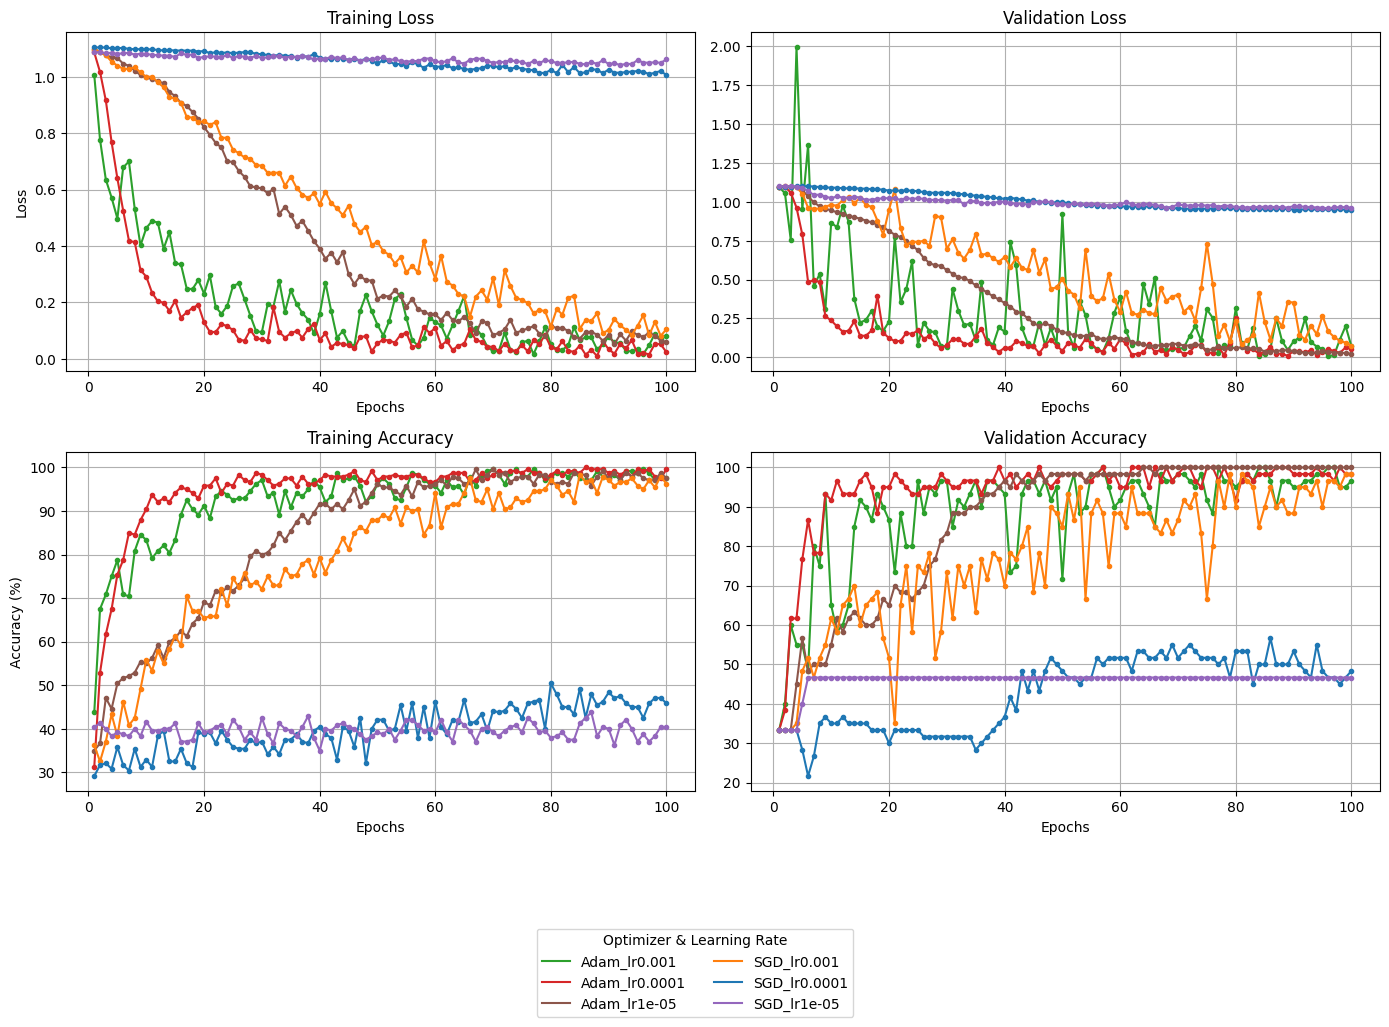

In [105]:
# Plot Training Metrix
plot_training_metrics(all_results, num_epochs=100)

## **`Evaluations Model`**
> Confusion Matrix and ROC/AUC Curve

### **`Confussion Matrix`**
> Meliputi rekap dari akurasi, presisi, recall, sensitivity dan F1-Score


Evaluating model: Adam_lr0.001
Accuracy: 0.9333
Precision: 0.9399
Sensitivity (Recall): 0.9333
Specificity: 0.9656
F1-Score: 0.9331


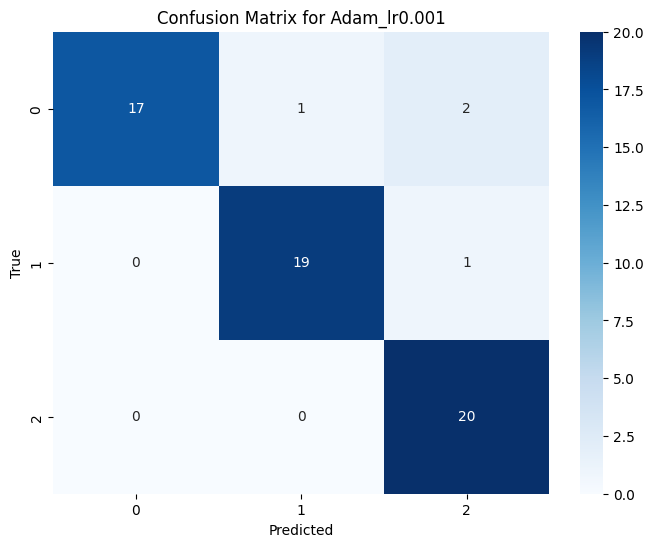

Classification Report for Adam_lr0.001
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.95      0.95      0.95        20
           2       0.87      1.00      0.93        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60


Evaluating model: Adam_lr0.0001
Accuracy: 0.9667
Precision: 0.9697
Sensitivity (Recall): 0.9667
Specificity: 0.9833
F1-Score: 0.9670


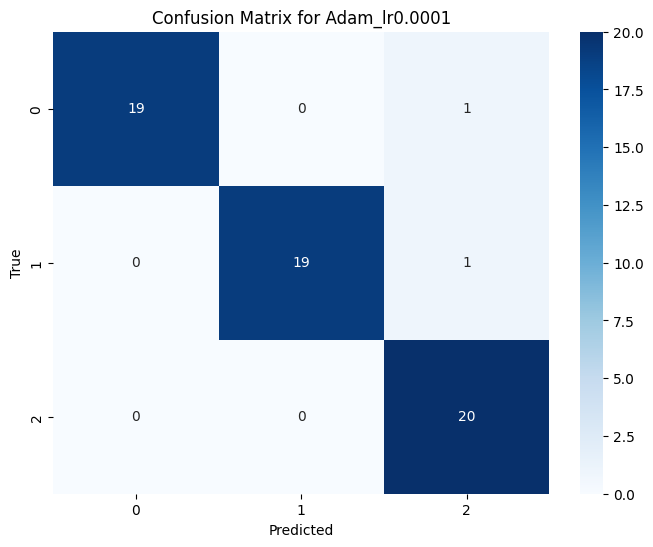

Classification Report for Adam_lr0.0001
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      0.95      0.97        20
           2       0.91      1.00      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Evaluating model: Adam_lr1e-05
Accuracy: 0.9500
Precision: 0.9516
Sensitivity (Recall): 0.9500
Specificity: 0.9748
F1-Score: 0.9504


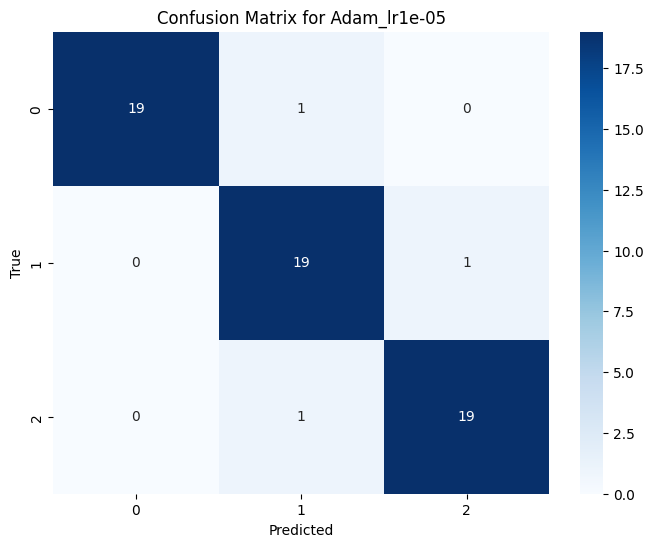

Classification Report for Adam_lr1e-05
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.90      0.95      0.93        20
           2       0.95      0.95      0.95        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60


Evaluating model: SGD_lr0.001
Accuracy: 0.9667
Precision: 0.9697
Sensitivity (Recall): 0.9667
Specificity: 0.9833
F1-Score: 0.9666


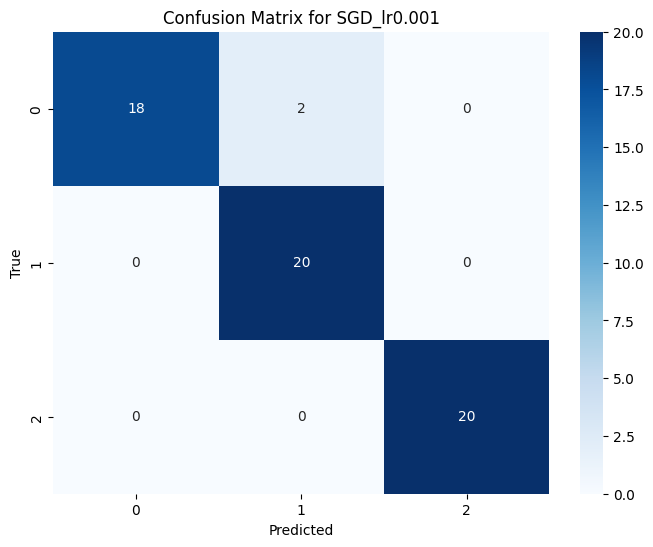

Classification Report for SGD_lr0.001
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20
           2       1.00      1.00      1.00        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Evaluating model: SGD_lr0.0001
Accuracy: 0.6000
Precision: 0.6551
Sensitivity (Recall): 0.6000
Specificity: 0.7643
F1-Score: 0.5969


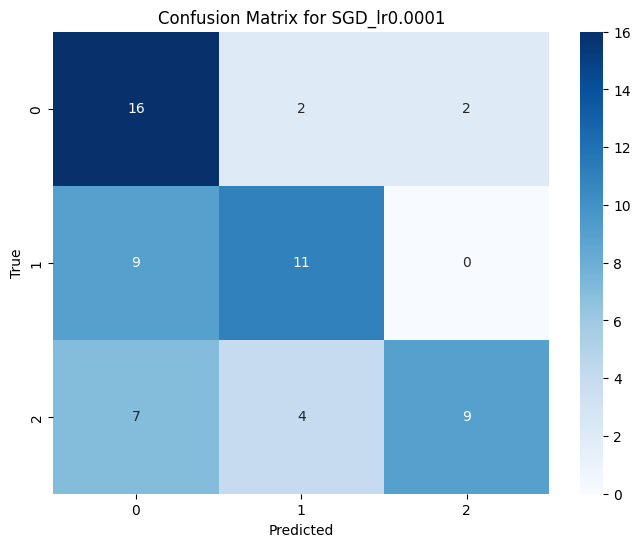

Classification Report for SGD_lr0.0001
              precision    recall  f1-score   support

           0       0.50      0.80      0.62        20
           1       0.65      0.55      0.59        20
           2       0.82      0.45      0.58        20

    accuracy                           0.60        60
   macro avg       0.66      0.60      0.60        60
weighted avg       0.66      0.60      0.60        60


Evaluating model: SGD_lr1e-05
Accuracy: 0.4333
Precision: 0.6021
Sensitivity (Recall): 0.4333
Specificity: 0.6408
F1-Score: 0.4018


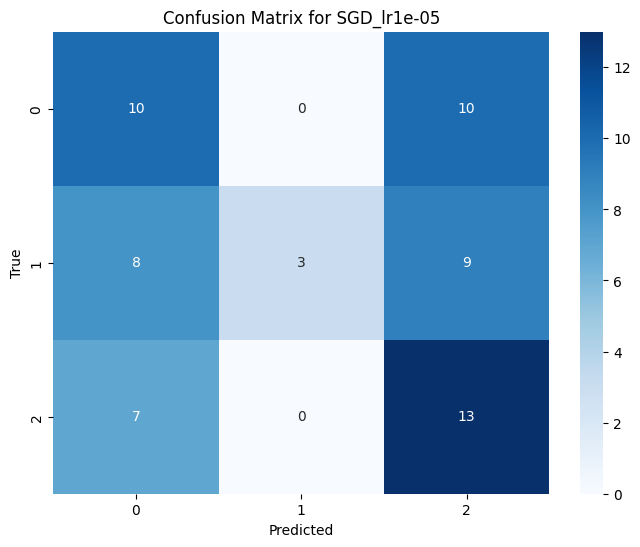

Classification Report for SGD_lr1e-05
              precision    recall  f1-score   support

           0       0.40      0.50      0.44        20
           1       1.00      0.15      0.26        20
           2       0.41      0.65      0.50        20

    accuracy                           0.43        60
   macro avg       0.60      0.43      0.40        60
weighted avg       0.60      0.43      0.40        60



In [106]:
# === CALCULATE METRICS ===
def calculate_metrics(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    TN = np.diag(cm).sum() - np.diag(cm)   # True Negative
    FP = cm.sum(axis=0) - np.diag(cm)      # False Positive
    FN = cm.sum(axis=1) - np.diag(cm)      # False Negative
    TP = np.diag(cm)                       # True Positive
    
    accuracy = accuracy_score(y_true, y_pred) # Skor akurasi
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0) # Skor presisi
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)  # Skor recall (sensitivitas)
    specificity = np.mean(TN / (TN + FP + 1e-7))  # Skor spesifisitas
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0) # F1-Score
    
    return accuracy, precision, recall, specificity, f1

for key in all_results.keys():
    print(f"\nEvaluating model: {key}")
    
    # Load model terbaik untuk konfigurasi ini
    model_path = f"/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_{key}.pth"
    model = Res4Net_CBAM(num_classes=3).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute metrics
    accuracy, precision, recall, specificity, f1 = calculate_metrics(all_labels, all_preds, num_classes=3)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
    plt.title(f'Confusion Matrix for {key}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(f"Classification Report for {key}")
    print(classification_report(all_labels, all_preds))

### **`ROC Curve`**
> Kurva ROC dari setiap kelas


Evaluating ROC Curve for model: Adam_lr0.001


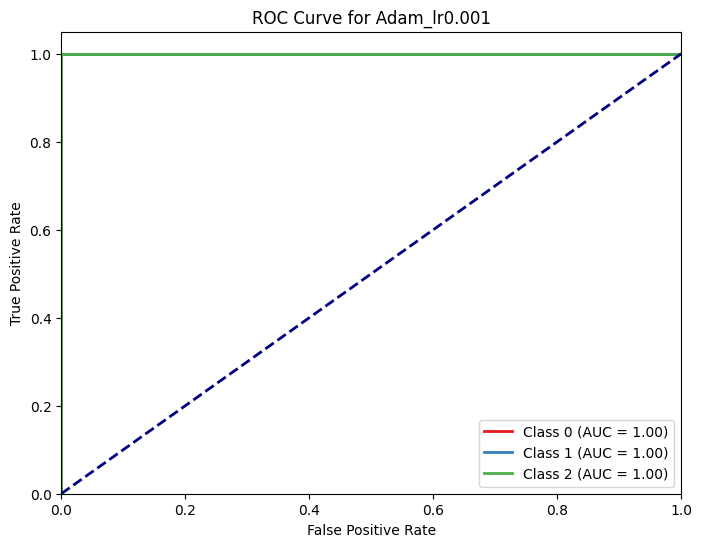

Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 1.00

Evaluating ROC Curve for model: Adam_lr0.0001


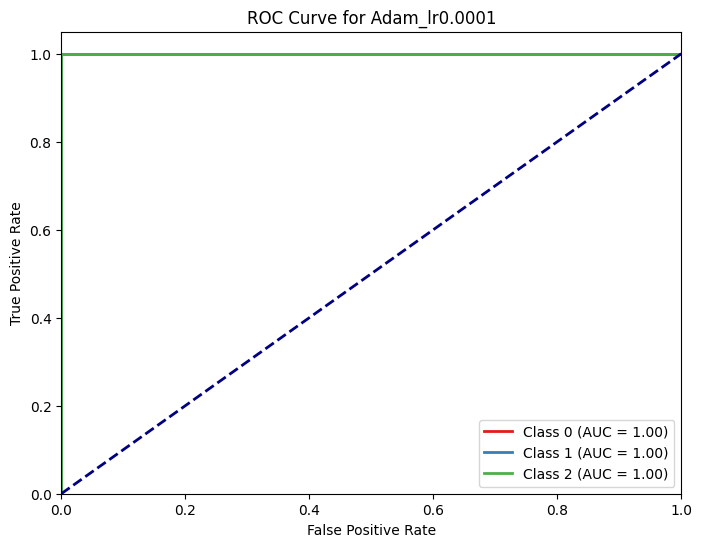

Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 1.00

Evaluating ROC Curve for model: Adam_lr1e-05


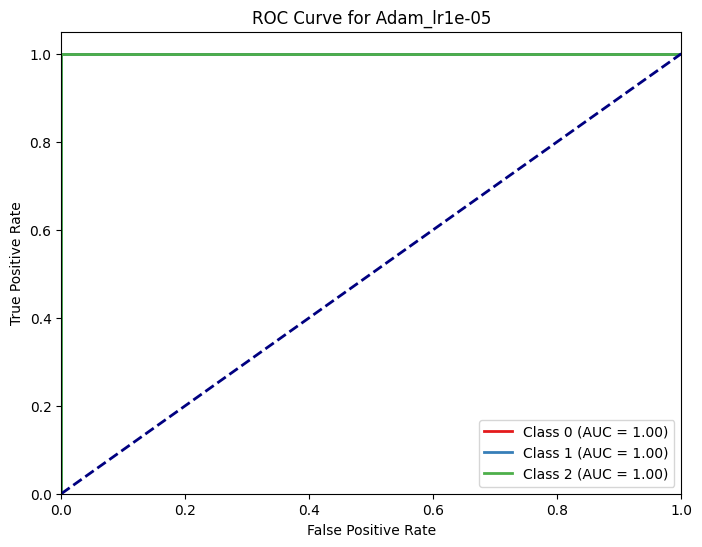

Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 1.00

Evaluating ROC Curve for model: SGD_lr0.001


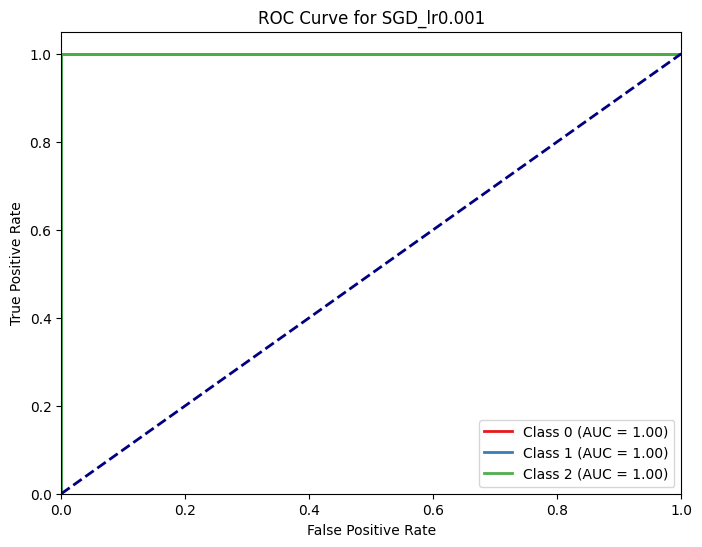

Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 1.00

Evaluating ROC Curve for model: SGD_lr0.0001


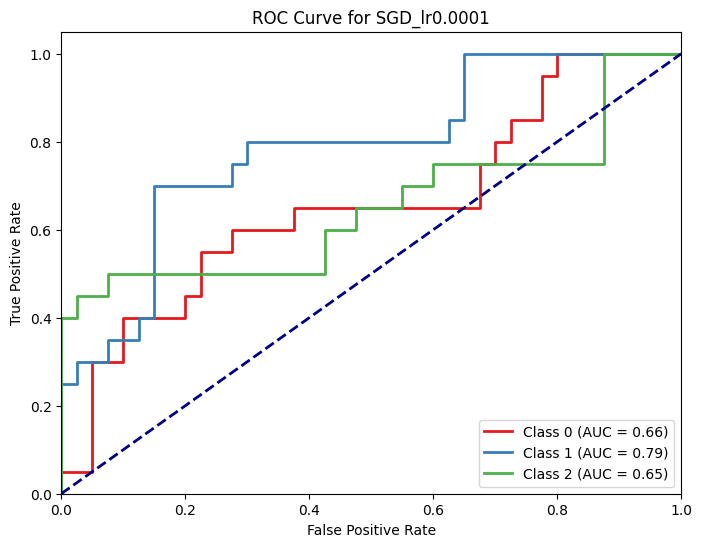

Class 0 AUC: 0.66
Class 1 AUC: 0.79
Class 2 AUC: 0.65

Evaluating ROC Curve for model: SGD_lr1e-05


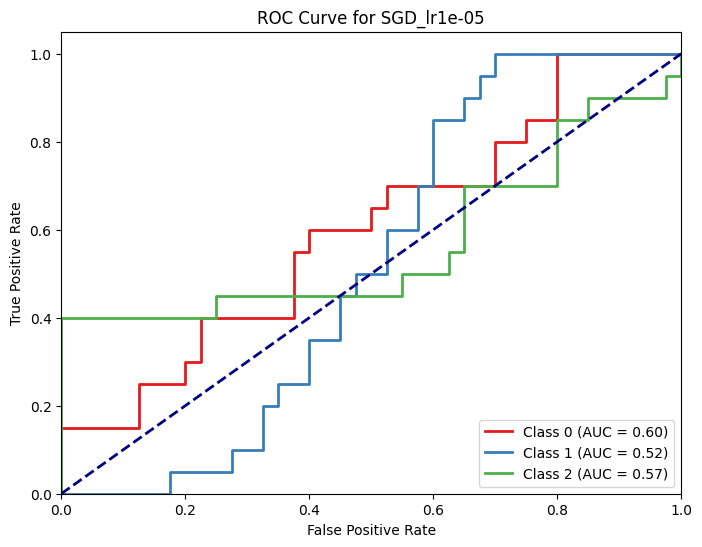

Class 0 AUC: 0.60
Class 1 AUC: 0.52
Class 2 AUC: 0.57


In [102]:
n_classes = 3  # Sesuaikan dengan jumlah kelas

for key in all_results.keys():
    print(f"\nEvaluating ROC Curve for model: {key}")
    
    # Load model terbaik untuk konfigurasi ini
    model_path = f"/kaggle/working/checkpoints/Res4Net_CBAM_{key}.pth"
    model = Res4Net_CBAM(num_classes=n_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Simpan label asli
            all_labels.extend(labels.cpu().numpy())
            
            # Konversi output ke probabilitas dengan softmax
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    fpr = {} # FPR 
    tpr = {} # TPR 
    roc_auc = {} # ROC/AUC

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=sns.color_palette("Set1")[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot diagonal (no skill)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC Curve for {key}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Print AUC per kelas
    for i in range(n_classes):
        print(f'Class {i} AUC: {roc_auc[i]:.2f}')

## **`Saving Model`**
> Menyimpan seluruh kombinasi model yang sudah dilatih sebelumnya

In [ ]:
import zipfile
from IPython.display import FileLink

def zip_pth_files(folder_path, output_zip_name="models.zip"):
    output_folder = "/kaggle/working"  # Direktori output tetap di /kaggle/working
    zip_file_path = os.path.join(output_folder, output_zip_name) # gabungkan output_folder dengan nama file zip

    try:
        with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for filename in os.listdir(folder_path):
                if filename.endswith(".pth"):
                    file_path = os.path.join(folder_path, filename)
                    zipf.write(file_path, arcname=filename)

        print(f"File zip '{output_zip_name}' telah dibuat dan disimpan di: {output_folder}")

        # Menampilkan link download di notebook Kaggle
        display(FileLink(zip_file_path))

    except FileNotFoundError:
        print(f"Error: Folder '{folder_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Contoh penggunaan:
folder_path = "/kaggle/working/checkpoints"  # Ganti dengan path folder Anda
zip_pth_files(folder_path)  # Membuat models.zip di /kaggle/working dan menampilkan link download

## **`Grad-CAM Visualization`**
> Melihat hasil visualisasi pada area konvolusi terakhir

In [100]:
model_cbam = Res4Net_CBAM(num_classes=3) # 3 Classes
print(model_cbam) # Print model

Res4Net_CBAM(
  (initial_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_block_cbam1): ResidualBlock(
    (leaky_relu1_branch): LeakyReLU(negative_slope=0.01)
    (conv1_branch): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1_branch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu2_branch): LeakyReLU(negative_slope=0.01)
    (conv2_branch): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2_branch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_relu3_branch): LeakyReLU(negative_slope=0.01)
    (conv3_branch): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3_branch): BatchNorm2d(

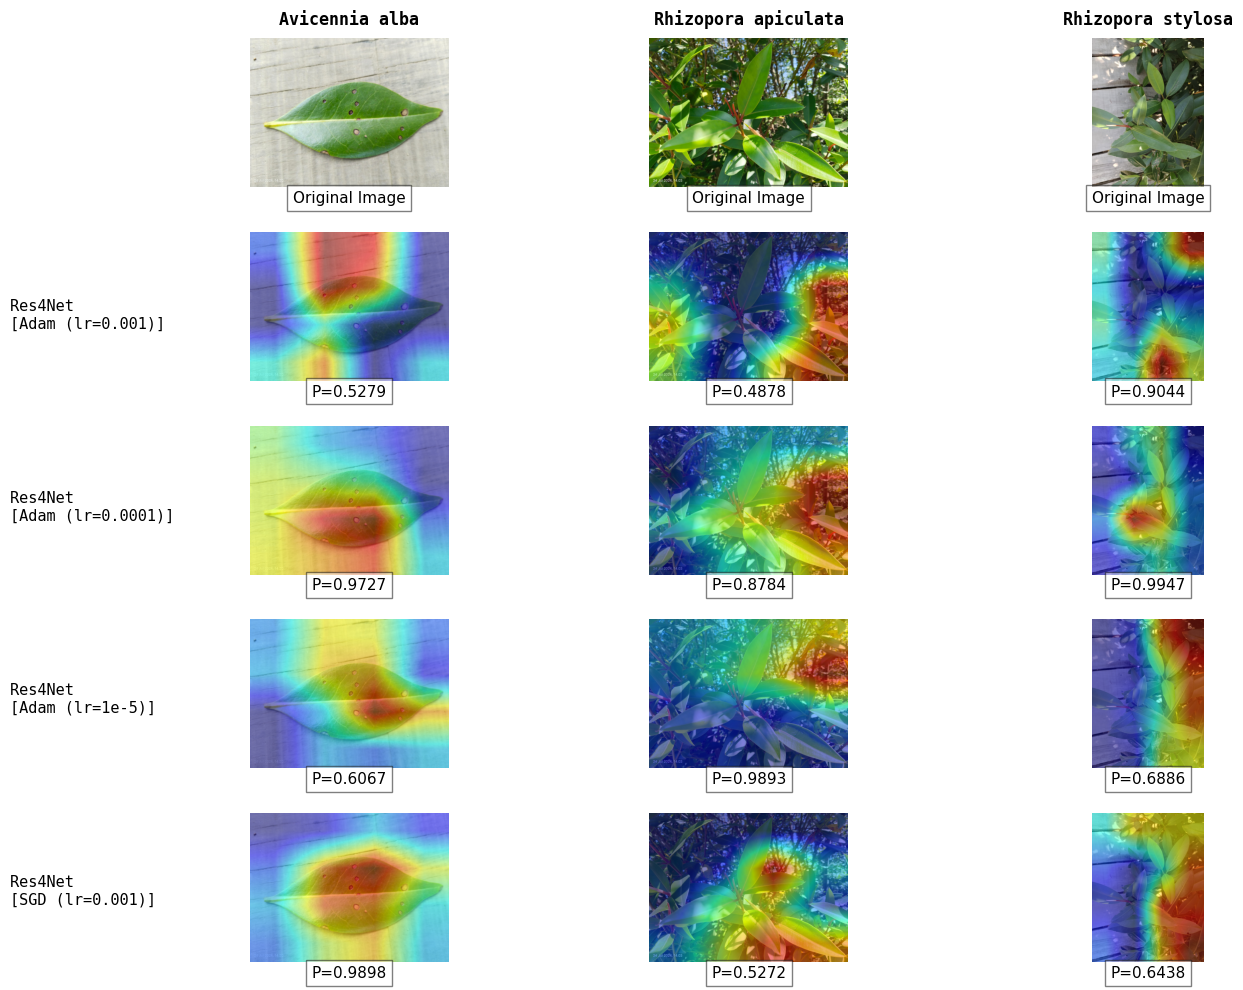

In [ ]:
# === Grad-CAM Visualizaton (Fine-grained) ===
def load_model(model_path, model_class, num_classes):
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def set_hooks(model, target_layer):
    features = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal features
        features = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    return lambda: features, lambda: gradients

def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor, img

def compute_gradcam(model, img_tensor, get_features, get_gradients, class_idx=None):
    output = model(img_tensor)
    probs = F.softmax(output, dim=1)

    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    output[0, class_idx].backward()

    features = get_features()
    gradients = get_gradients()

    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * features, dim=1).squeeze(0)

    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()

    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    return cam, probs[0, class_idx].item()

def compare_models(image_paths, model_paths, model_classes, num_classes, species_names):
    models = [load_model(model_paths[i], model_classes[i], num_classes) for i in range(len(model_paths))]
    target_layers = [getattr(model, "residual_block_cbam4", None) for model in models]
    hooks = [set_hooks(models[i], target_layers[i]) if target_layers[i] else None for i in range(len(models))]

    fig, axes = plt.subplots(len(models) + 1, len(image_paths), figsize=(15, 12))  # Tambahkan baris untuk gambar asli

    # Baris pertama: Menampilkan gambar asli dengan judul spesies
    for j, img_path in enumerate(image_paths):
        img_tensor, img_pil = preprocess_image(img_path)
        axes[0, j].imshow(img_pil)
        axes[0, j].set_title(species_names[j], fontsize=12, fontweight="bold", family="monospace", pad=10)
        axes[0, j].axis("off")
        axes[0, j].text(0.5, -0.1, "Original Image", fontsize=11, ha="center", transform=axes[0, j].transAxes, bbox=dict(facecolor='white', alpha=0.5))

    model_labels = [
        "Res4Net \n[Adam (lr=0.001)]",
        "Res4Net \n[Adam (lr=0.0001)]",
        "Res4Net \n[Adam (lr=1e-5)]",
        "Res4Net \n[SGD (lr=0.001)]"
    ]

    for i in range(len(models)):
        for j, img_path in enumerate(image_paths):
            img_tensor, img_pil = preprocess_image(img_path)

            if hooks[i]:
                cam, prob = compute_gradcam(models[i], img_tensor, *hooks[i])
                overlay = overlay_gradcam(img_pil, cam)
                axes[i + 1, j].imshow(overlay)
                axes[i + 1, j].text(0.5, -0.1, f"P={prob:.4f}", fontsize=11, ha="center", transform=axes[i + 1, j].transAxes, bbox=dict(facecolor='white', alpha=0.5))
            else:
                axes[i + 1, j].imshow(img_pil)
                axes[i + 1, j].text(0.5, -0.1, "No CAM", fontsize=11, ha="center", transform=axes[i + 1, j].transAxes, bbox=dict(facecolor='white', alpha=0.5))
            
            axes[i + 1, j].axis("off")
    
    # Menampilkan label model di samping subplot agar tidak berantakan
    for i, label in enumerate(model_labels):
        fig.text(0.02, 0.81 - ((i + 1) * 0.16), label, fontsize=11, va="center", ha="left", family="monospace")

    plt.subplots_adjust(hspace=0.3, wspace=0.1)  # Lebih proporsional
    plt.show()


# Gantilah dengan path gambar dan model yang digunakan
image_paths = [
    "/kaggle/input/mangrove-tester/Avicennia_Alba_745/Avicennia_110.jpg", 
    "/kaggle/input/mangrove-tester/Rhizopora_Apiculata_749/Apiculata_117.jpg", 
    "/kaggle/input/mangrove-tester/Rhizopora Stylosa_756/Stylosa_15.jpg"
]  

model_paths = [
    "/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr0.001.pth", 
    "/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr0.0001.pth", 
    "/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr1e-05.pth",
    "/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_SGD_lr0.001.pth"
]

species_names = ["Avicennia alba", "Rhizopora apiculata", "Rhizopora stylosa"]
model_classes = [Res4Net_CBAM] * len(model_paths)  # Menggunakan list comprehension agar lebih ringkas
num_classes = 3  # Sesuaikan dengan jumlah kelas

compare_models(image_paths, model_paths, model_classes, num_classes, species_names)

## **`Testing Model`**
> Predicted with new data from Cuku NyiNyi

In [91]:
# Fungsi untuk memanggil model yang sudah disimpan sebelumnya untuk dilakukan pengujian
def load_model(model, load_path, device):
    state_dict = torch.load(load_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict) # Load state dictionary ke dalam model 
    model.to(device) # Model dikirim ke device yang tersedia
    model.eval()  # Setel model dalam mode evaluasi mode
    print(f"Model loaded from {load_path}") # Mencetak dimana lokasi model dibuat
    return model # Kembalikan ke variabel model

In [92]:
# Model 1
model_1 = Res4Net_CBAM(num_classes=3)  # Inisialisasi Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Setting device yang tersedia
model_1 = load_model(model_1, '/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr0.001.pth', device)  # Siapkan model yang sudah disimpan

Model loaded from /kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr0.001.pth


In [93]:
# Model 2
model_2 = Res4Net_CBAM(num_classes=3)  # Inisialisasi Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Setting device yang tersedia
model_2 = load_model(model_2, '/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr0.0001.pth', device)  # Siapkan model yang sudah disimpan

Model loaded from /kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr0.0001.pth


In [94]:
# Model 3
model_3 = Res4Net_CBAM(num_classes=3)  # Inisialisasi Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Setting device yang tersedia
model_3 = load_model(model_3, '/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr1e-05.pth', device)  # Siapkan model yang sudah disimpan

Model loaded from /kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_Adam_lr1e-05.pth


In [95]:
model_4 = Res4Net_CBAM(num_classes=3)  # Inisialisasi Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Setting device yang tersedia
model_4 = load_model(model_4, '/kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_SGD_lr0.001.pth', device)  # Siapkan model yang sudah disimpan

Model loaded from /kaggle/input/res4net-cbam_varian_original/pytorch/sgd_adam_learner/1/Res4Net_CBAM_SGD_lr0.001.pth


### **`Prediksi Gambar`**

In [124]:
def predict_image_with_plot(model, image_path, device, num_classes):
    """Predicts the class of a single image using the trained model and displays the result."""

    # Load and preprocess the image
    img = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Match the input size used during training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # Perform prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()

    # Plot the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(image_path))  # Display the original image
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.4f}", fontsize=12)
    plt.show()

    return predicted_class, confidence

# Example usage with a list of image paths
image_paths = ["/kaggle/input/mangrove-tester/Avicennia_Alba_745/Avicennia_1.JPG",
               "/kaggle/input/mangrove-tester/Rhizopora_Apiculata_749/Apiculata_111.jpg",
              "/kaggle/input/mangrove-tester/Rhizopora Stylosa_756/Stylosa_24.jpg"]

# Define the class mapping
class_mapping = {
    0: "Avicennia alba",
    1: "Rhizopora apiculata",
    2: "Rhizopora stylosa"
}

#### **Adam (lr=10^-3)**

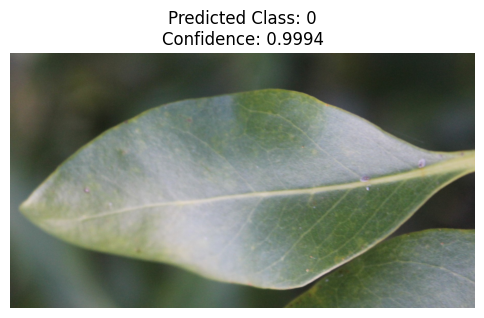

Image: /kaggle/input/mangrove-tester/Avicennia_Alba_745/Avicennia_1.JPG
Predicted Class: Avicennia alba (ID: 0)
Confidence: 0.9994


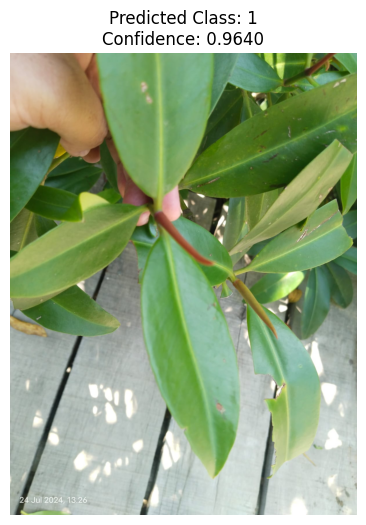

Image: /kaggle/input/mangrove-tester/Rhizopora_Apiculata_749/Apiculata_111.jpg
Predicted Class: Rhizopora apiculata (ID: 1)
Confidence: 0.9640


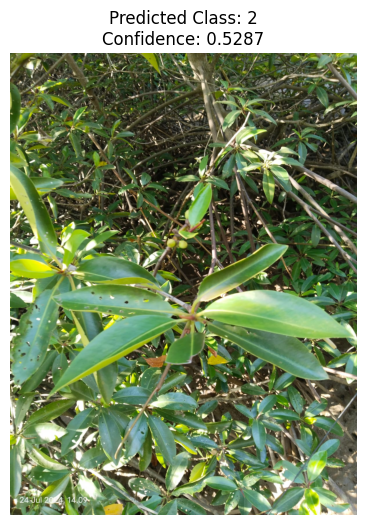

Image: /kaggle/input/mangrove-tester/Rhizopora Stylosa_756/Stylosa_24.jpg
Predicted Class: Rhizopora stylosa (ID: 2)
Confidence: 0.5287


In [125]:
num_classes = 3
# Example of using the mapping after prediction
for image_path in image_paths:
    try:
        predicted_class, confidence = predict_image_with_plot(model_1, image_path, device, num_classes)

        # Get the class name from the dictionary
        class_name = class_mapping.get(predicted_class, "Unknown")

        print(f"Image: {image_path}")
        print(f"Predicted Class: {class_name} (ID: {predicted_class})")
        print(f"Confidence: {confidence:.4f}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

#### **Adam (lr=10^-4)**

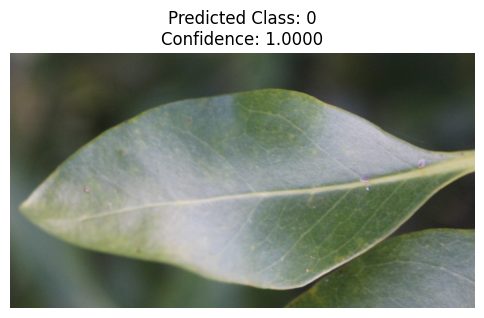

Image: /kaggle/input/mangrove-tester/Avicennia_Alba_745/Avicennia_1.JPG
Predicted Class: Avicennia alba (ID: 0)
Confidence: 1.0000


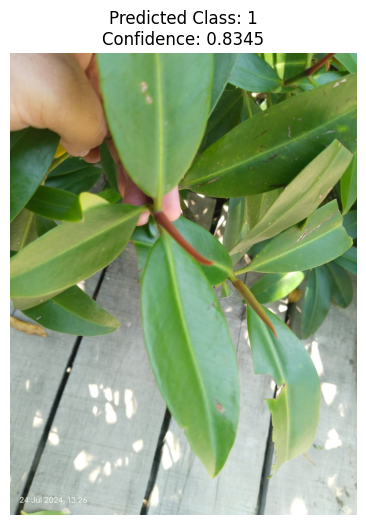

Image: /kaggle/input/mangrove-tester/Rhizopora_Apiculata_749/Apiculata_111.jpg
Predicted Class: Rhizopora apiculata (ID: 1)
Confidence: 0.8345


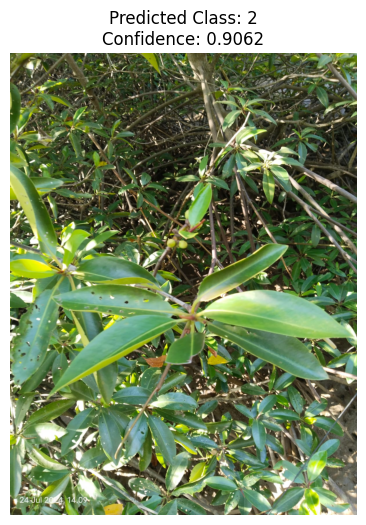

Image: /kaggle/input/mangrove-tester/Rhizopora Stylosa_756/Stylosa_24.jpg
Predicted Class: Rhizopora stylosa (ID: 2)
Confidence: 0.9062


In [126]:
num_classes = 3
# Example of using the mapping after prediction
for image_path in image_paths:
    try:
        predicted_class, confidence = predict_image_with_plot(model_2, image_path, device, num_classes)

        # Get the class name from the dictionary
        class_name = class_mapping.get(predicted_class, "Unknown")

        print(f"Image: {image_path}")
        print(f"Predicted Class: {class_name} (ID: {predicted_class})")
        print(f"Confidence: {confidence:.4f}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

#### **Adam (lr=10^-5)**

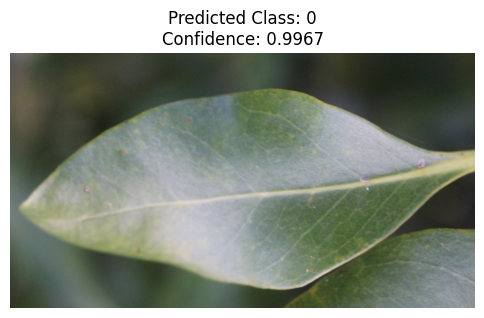

Image: /kaggle/input/mangrove-tester/Avicennia_Alba_745/Avicennia_1.JPG
Predicted Class: Avicennia alba (ID: 0)
Confidence: 0.9967


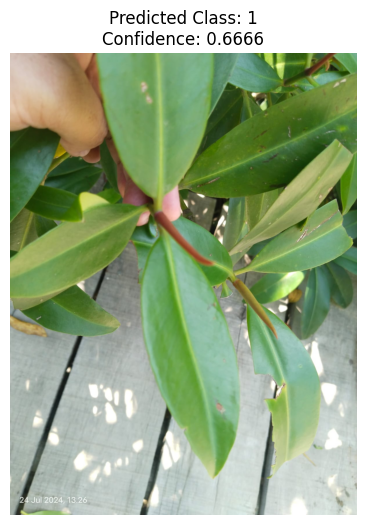

Image: /kaggle/input/mangrove-tester/Rhizopora_Apiculata_749/Apiculata_111.jpg
Predicted Class: Rhizopora apiculata (ID: 1)
Confidence: 0.6666


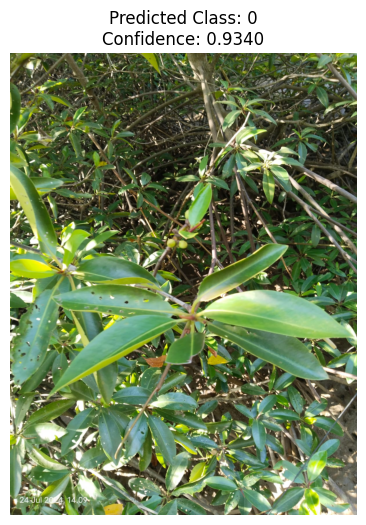

Image: /kaggle/input/mangrove-tester/Rhizopora Stylosa_756/Stylosa_24.jpg
Predicted Class: Avicennia alba (ID: 0)
Confidence: 0.9340


In [127]:
num_classes = 3
# Example of using the mapping after prediction
for image_path in image_paths:
    try:
        predicted_class, confidence = predict_image_with_plot(model_3, image_path, device, num_classes)

        # Get the class name from the dictionary
        class_name = class_mapping.get(predicted_class, "Unknown")

        print(f"Image: {image_path}")
        print(f"Predicted Class: {class_name} (ID: {predicted_class})")
        print(f"Confidence: {confidence:.4f}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")